In [1]:
import os, sys
import numpy as np
import healpy as hp
import pandas as pd
import h5py
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

os.system('module load texlive/2022')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times",
    "font.size"  : 13
})

matplotlib.rcParams.update({'font.size': 15})

matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rc('text.latex', preamble=r'\usepackage{/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/apjfonts}')
        
#plt.rcParams["font.family"] = "Times New Roman"

plt.rcParams['axes.facecolor']   = 'w'
plt.rcParams['figure.facecolor'] = 'w'


kidscol = '#9CC363'    # light olive
descol  = 'chocolate'  # dark orange
hsccol  = '#5A8BAF'    # lightpurple

# Footprint

In [163]:
#kids=hp.read_map('/lcrc/project/SPT3G/users/ac.yomori/projects/nulltest/masks/mask_kids1000.fits',partial=True)
import h5py

kids=np.zeros(hp.nside2npix(128))
with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/kids/outputs/meansubperfield/source_maps.hdf5', "r") as f:
    #c=f['maps']['count_2D'][:]
    px  = f['maps']['count_2D']['pixel'][:]
    val = f['maps']['count_2D']['value'][:]
    
kids[px]=val
kids[kids>0]=1   
    

hsc=np.zeros(hp.nside2npix(1024))
with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/hsc-y3/outputs/shearsys/source_maps.hdf5', "r") as f:
    #c=f['maps']['count_2D'][:]
    px  = f['maps']['count_2D']['pixel'][:]
    val = f['maps']['count_2D']['value'][:]
    
hsc[px]=val  
hsc=hp.ud_grade(hsc,power=-2,nside_out=128)
hsc[hsc>0]=1 


des=np.zeros(hp.nside2npix(128))
with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/desy3a/outputs/source_maps.hdf5', "r") as f:
    #c=f['maps']['count_2D'][:]
    px  = f['maps']['count_2D']['pixel'][:]
    val = f['maps']['count_2D']['value'][:]
    
des[px]=val  
des=hp.ud_grade(des,power=-2,nside_out=128)
des[des>0]=1 


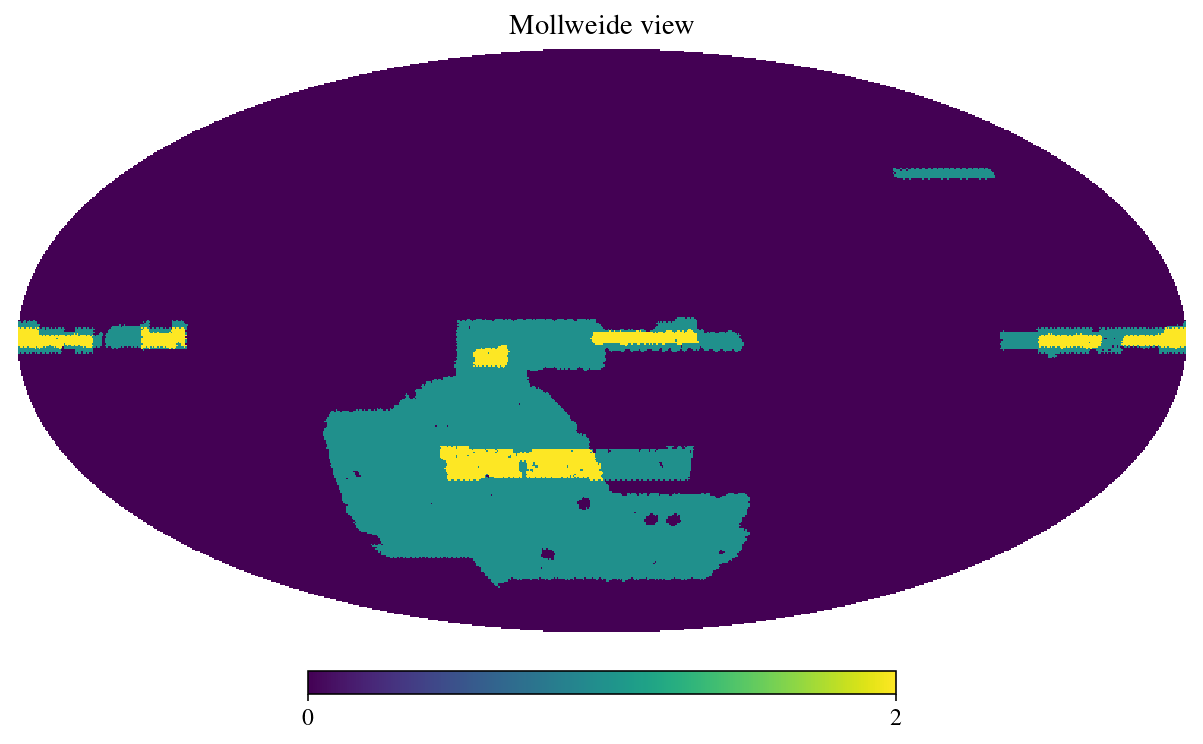

In [169]:
hp.mollview(kids+hsc+des)


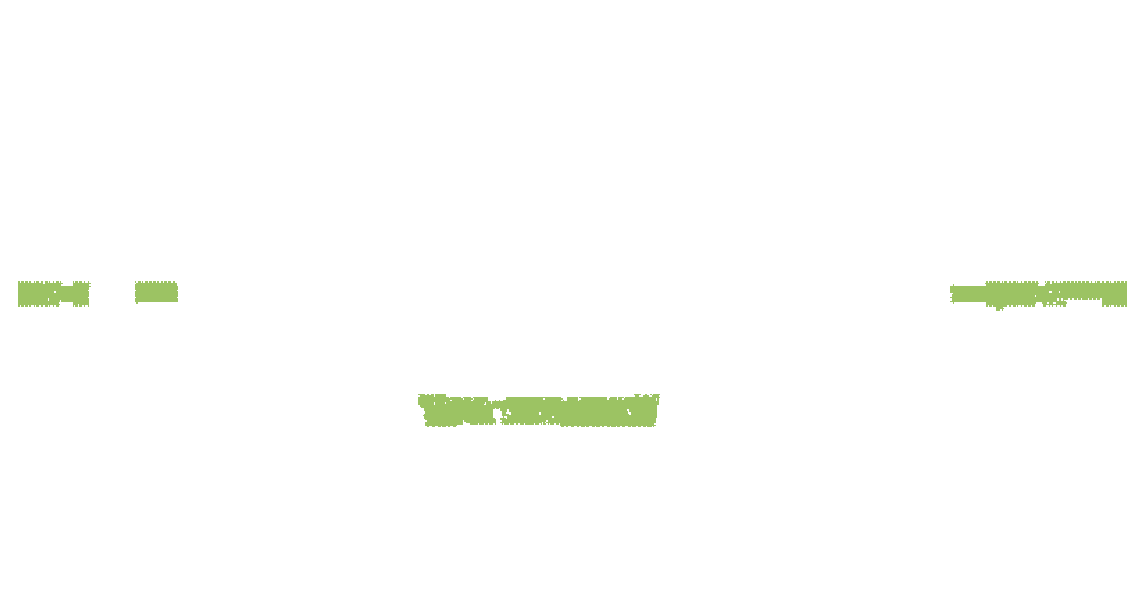

In [153]:
# KiDS-1000
import matplotlib.colors as mcolors
fig=plt.figure(figsize=(10,6))
plt.rcParams['axes.facecolor']='None'
plt.rcParams['savefig.facecolor']='None'

#colors = [(0.25,0.75,0,c) for c in np.linspace(0,0.5,100)]
#cmaporange = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)



cvals  = [0,1]
colors = ["w",kidscol]
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmapkids = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
cmapkids.set_under('k', alpha=0)
cmapkids.set_bad('k', alpha=0)

hp.mollview(kids,badcolor='None',hold=True,cmap=cmapkids,fig=fig,alpha=kids,cbar=False,title=None)
fig.patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.gca().set_facecolor("orange")
plt.savefig('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/plots/footprint_kids.png',transparent=True,facecolor='None')

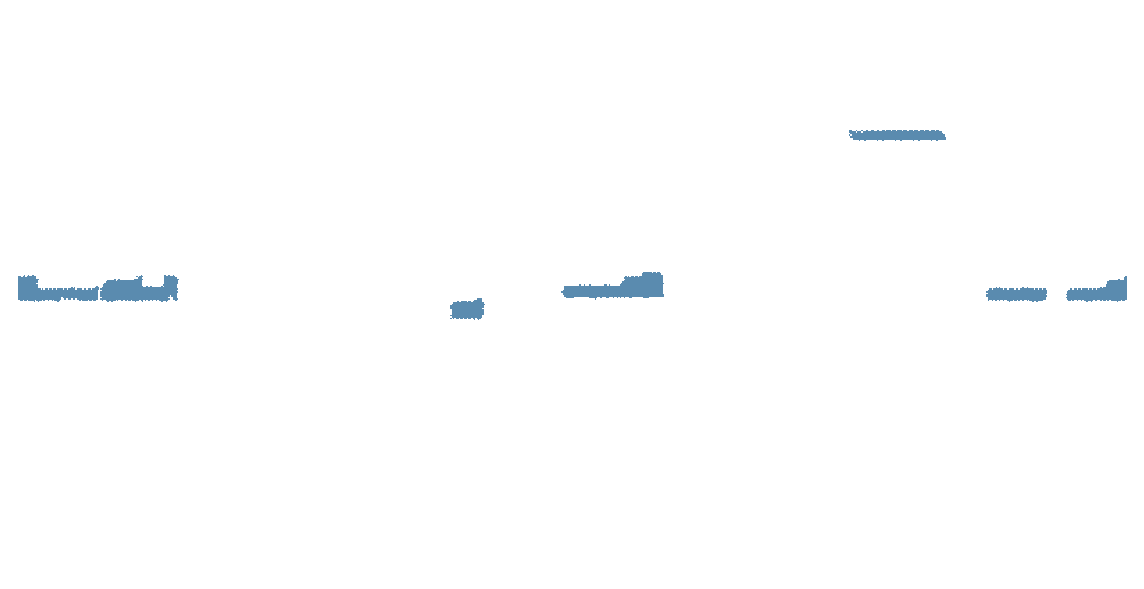

In [155]:
# HSC-Y3
import matplotlib.colors as mcolors
fig=plt.figure(figsize=(10,6))
#hp.mollview(desy3,badcolor='None',hold=True,cmap=cmapblue,fig=fig,)

plt.rcParams['axes.facecolor']='None'
plt.rcParams['savefig.facecolor']='None'


cvals  = [0,1]
colors = ["w",hsccol]
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmaphsc = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
cmaphsc.set_under('k', alpha=0)
cmaphsc.set_bad('k', alpha=0)

#aa=np.ones_like(desy1)*hp.UNSEEN
hp.mollview(hsc,badcolor='None',hold=True,cmap=cmaphsc,fig=fig,alpha=hsc,cbar=False,title=None)
#hp.graticule(lw=0.1,alpha=0.4,dpar=30,dmer=30)
fig.patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.gca().set_facecolor("orange")
plt.savefig('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/plots/footprint_hsc.png',transparent=True,facecolor='None')

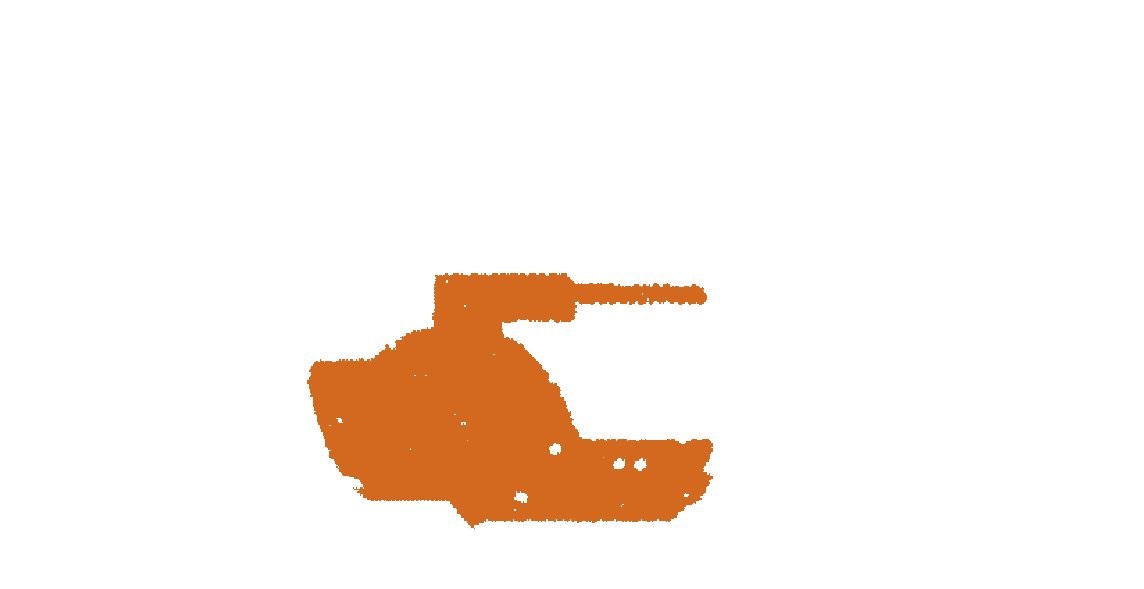

In [175]:
# HSC-Y3
import matplotlib.colors as mcolors
fig=plt.figure(figsize=(10,6))
#hp.mollview(desy3,badcolor='None',hold=True,cmap=cmapblue,fig=fig,)

plt.rcParams['axes.facecolor']='None'
plt.rcParams['savefig.facecolor']='None'


cvals  = [0,1]
colors = ["w",descol]
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmaphsc = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
cmaphsc.set_under('k', alpha=0)
cmaphsc.set_bad('k', alpha=0)

#aa=np.ones_like(desy1)*hp.UNSEEN
hp.mollview(des,badcolor='None',hold=True,cmap=cmaphsc,fig=fig,alpha=des,cbar=False,title=None)
#hp.graticule(lw=0.1,alpha=0.4,dpar=30,dmer=30)
fig.patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.gca().set_facecolor("orange")
plt.savefig('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/plots/footprint_des.png',transparent=True,facecolor='None')

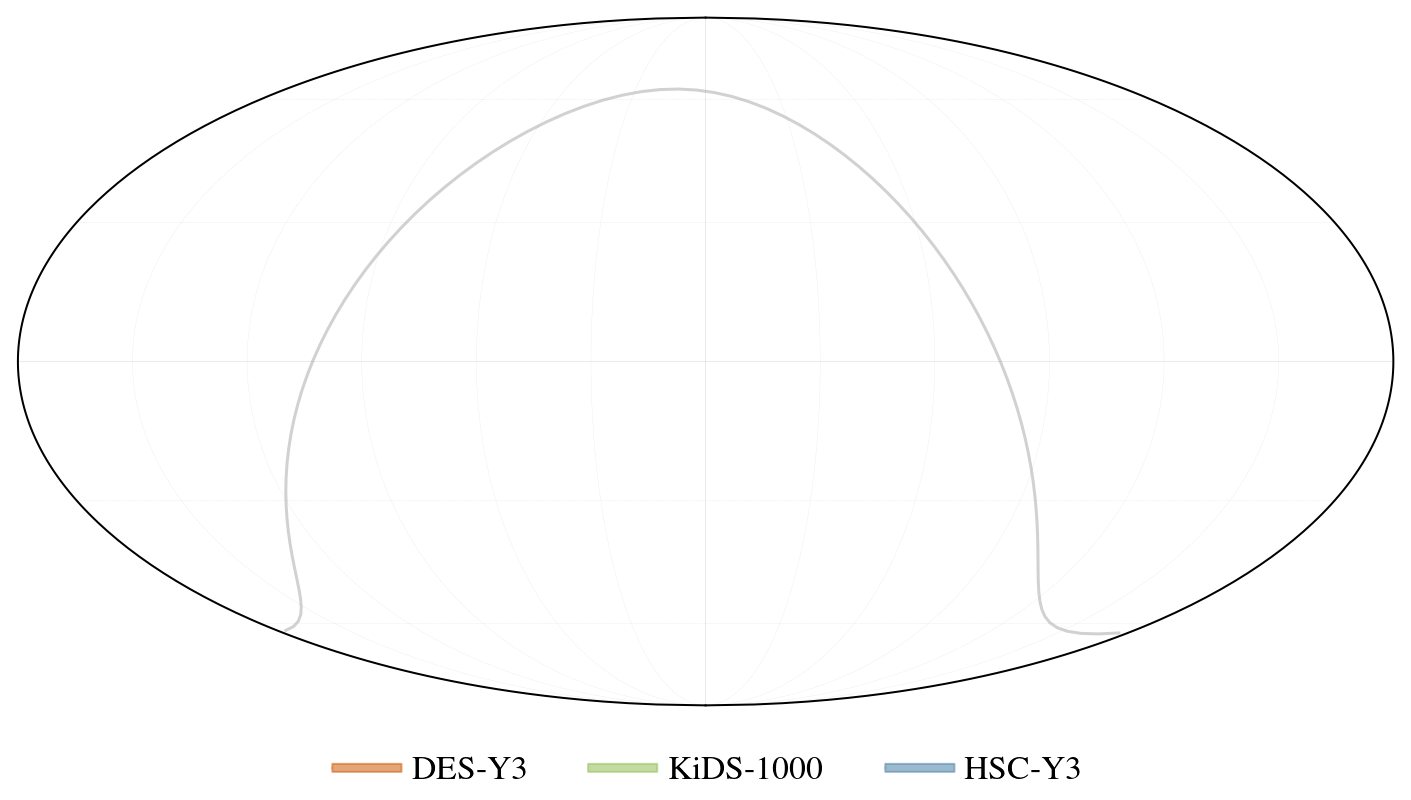

In [249]:
from astropy.coordinates import SkyCoord
import astropy.units as u

def rd2tp(ra,dec):
    """
    Convert ra,dec -> tht,phi
    """
    tht = (-dec+90.0)/180.0*np.pi
    phi = ra/180.0*np.pi
    return tht,phi
    
fig=plt.figure(figsize=(10,6))
#hp.mollview(desy3,badcolor='None',hold=True,cmap=cmapblue,fig=fig,)

plt.rcParams['axes.facecolor']='None'
plt.rcParams['savefig.facecolor']='None'
'''
cmap = cm.bwr
cmap.set_under('r',alpha=0.1)
cmap.set_bad('r',alpha=0.1)

#aa=np.ones_like(desy1)*hp.UNSEEN
hp.mollview(desy3*0,badcolor='None',hold=True,cmap='binary',fig=fig,alpha=desy3,cbar=False,title=None)
'''

'''
cvals  = [0,1]
colors = ["w",descol]
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmapdes = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
cmapdes.set_under('k', alpha=0)
cmapdes.set_bad('k', alpha=0)
hp.mollview(des*0.8,badcolor='None',hold=True,cmap='binary',fig=fig,cbar=False,title=None)
''';
hp.graticule(lw=0.2,alpha=0.2,dpar=30,dmer=30)
fig.patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.gca().set_facecolor("orange")


dec = np.asarray([0.]*100)
ra  = np.arange(0, 360, 3.6)


gc = SkyCoord(l=ra*u.degree, b=dec*u.degree, frame='galactic')
raC=gc.fk5.ra.value
decC=gc.fk5.dec.value

tht,phi=rd2tp(raC,decC)

hp.projplot(raC,decC, 'dimgray', lw=1.5,coord='G',lonlat=True,alpha=0.3)

#plt.gca().text(0.2,-0.10,'DES-Y1'   ,transform=plt.gca().transAxes,ha='center',fontsize=15)
plt.gca().text(0.33,-0.10,'DES-Y3'   ,transform=plt.gca().transAxes,ha='center',fontsize=17)
plt.gca().text(0.53,-0.10,'KiDS-1000',transform=plt.gca().transAxes,ha='center',fontsize=17)
plt.gca().text(0.73,-0.10,'HSC-Y3'      ,transform=plt.gca().transAxes,ha='center',fontsize=17)

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
#box = Rectangle((0.15, -0.1), 0.05, 0.05)
#pc  = PatchCollection(box, facecolor='r', alpha=0.5)
#plt.gca().add_collection(box,transform=plt.gca().transAxes)

#p = Rectangle((0.0, -0.05), 0.05, 0.05, fill=True,color='r',transform=plt.gca().transAxes)

#p.set_clip_on(False)
#plt.gca().add_patch(p)

plt.gca().annotate('', xy=(0.23, -0.085), xytext=(0.28,-0.085 ),xycoords='axes fraction',
            arrowprops=dict(facecolor=descol,edgecolor=descol,headwidth=0,headlength=0.001,alpha=0.6),fontsize=20            )

plt.gca().annotate('', xy=(0.415, -0.085), xytext=(0.465,-0.085 ),xycoords='axes fraction',
            arrowprops=dict(facecolor=kidscol,edgecolor=kidscol,headwidth=0,headlength=0.001,alpha=0.6),fontsize=20
            )

plt.gca().annotate('', xy=(0.63, -0.085), xytext=(0.68,-0.085 ),xycoords='axes fraction',
            arrowprops=dict(facecolor=hsccol,edgecolor=hsccol,headwidth=0,headlength=0.001,alpha=0.6),fontsize=20
            )


plt.savefig('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/plots/footprint_background.pdf',transparent=True,facecolor='None',dpi=400)




# Figure 1

# Various distributions

In [2]:
# Figure 2 shows various quantities of the shear catalogs post-processing.

# catalogs can be found here at NERSC:
desy3path = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/des-y3/shear_catalog_desy3_unmasked_withfakez_v2.h5'
hscy3path = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/hsc-y3/shear/txpipe_allfield_shear.h5'
kidspath  = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/kids/shear_catalog_kids1000.hdf5'

# We run TXPipe's SourceSelector
# and load the processed catalogs

with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/desy3a/outputs/shear_tomography_catalog.hdf5','r') as f:
    source_bin = f["tomography/bin"][:]
    mask = source_bin != -1
    R_total_2d = f["response/R_S_2d"][:] + f["response/R_gamma_mean_2d"][:]
    with h5py.File(desy3path,'r') as g:
        h = g['shear']
        des_g1   = h["mcal_g1"][:][mask] 
        des_g2   = h["mcal_g1"][:][mask]
        des_psfT = h["mcal_psf_T_mean"][:][mask]
        des_T    = h["mcal_T"][:][mask]
        des_snr  = h["mcal_s2n"][:][mask]
        # calibrate:
        des_g1,des_g2 = np.linalg.inv(R_total_2d) @ [des_g1,des_g2]

with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/hsc-y3/outputs/shearsys//shear_tomography_catalog.hdf5','r') as f:
    source_bin = f["tomography/bin"][:]
    mask = source_bin != -1  
    R = f['response/R_mean_2d'][0]
    K = f['response/K_2d'][0]
    with h5py.File(hscy3path,'r') as g: 
        h = g['shear']
        hsc_g1   = h['g1'][:][mask]
        hsc_g2   = h['g2'][:][mask]
        hsc_psfT = h['psf_T_mean'][:][mask]
        hsc_T    = h['T'][:][mask]
        hsc_snr  = h['s2n'][:][mask]
        # calibrate:
        hsc_g1 = ((hsc_g1 / (2 * R) - h['c1'][:][mask]) / (1 + K) - h['aselepsf1'][:][mask])/(1+h['msel'][:][mask])
        hsc_g2 = ((hsc_g2 / (2 * R) - h['c2'][:][mask]) / (1 + K) - h['aselepsf2'][:][mask])/(1+h['msel'][:][mask])

with h5py.File('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/kids/outputs/meansubperfield/shear_tomography_catalog.hdf5','r') as f:
    source_bin = f["tomography/bin"][:]
    mask = source_bin != -1
    c_n = f["response/C_2d_N"][:] 
    c_s = f["response/C_2d_S"][:]
    K   = f["response/K_2d"][:] 
    with h5py.File(kidspath,'r') as g:
        h = g['shear']
        kids_g1   = h['g1'][:][mask]
        kids_g2   = h['g2'][:][mask]
        kids_psfT = h['psf_T_mean'][:][mask]
        kids_T    = h['T'][:][mask]
        kids_snr  = h['s2n'][:][mask]
        # additive bias removal:
        Nmask = h['dec'][:][mask] > -25.0
        Smask = h['dec'][:][mask] <= -25.0

        kids_g1[Nmask] = (kids_g1[Nmask] - c_n[0]) / (1 + K)
        kids_g1[Smask] = (kids_g1[Smask] - c_s[0]) / (1 + K)
        kids_g2[Nmask] = (kids_g2[Nmask] - c_n[1]) / (1 + K)
        kids_g2[Smask] = (kids_g2[Smask] - c_s[1]) / (1 + K)
        

<Figure size 640x480 with 0 Axes>

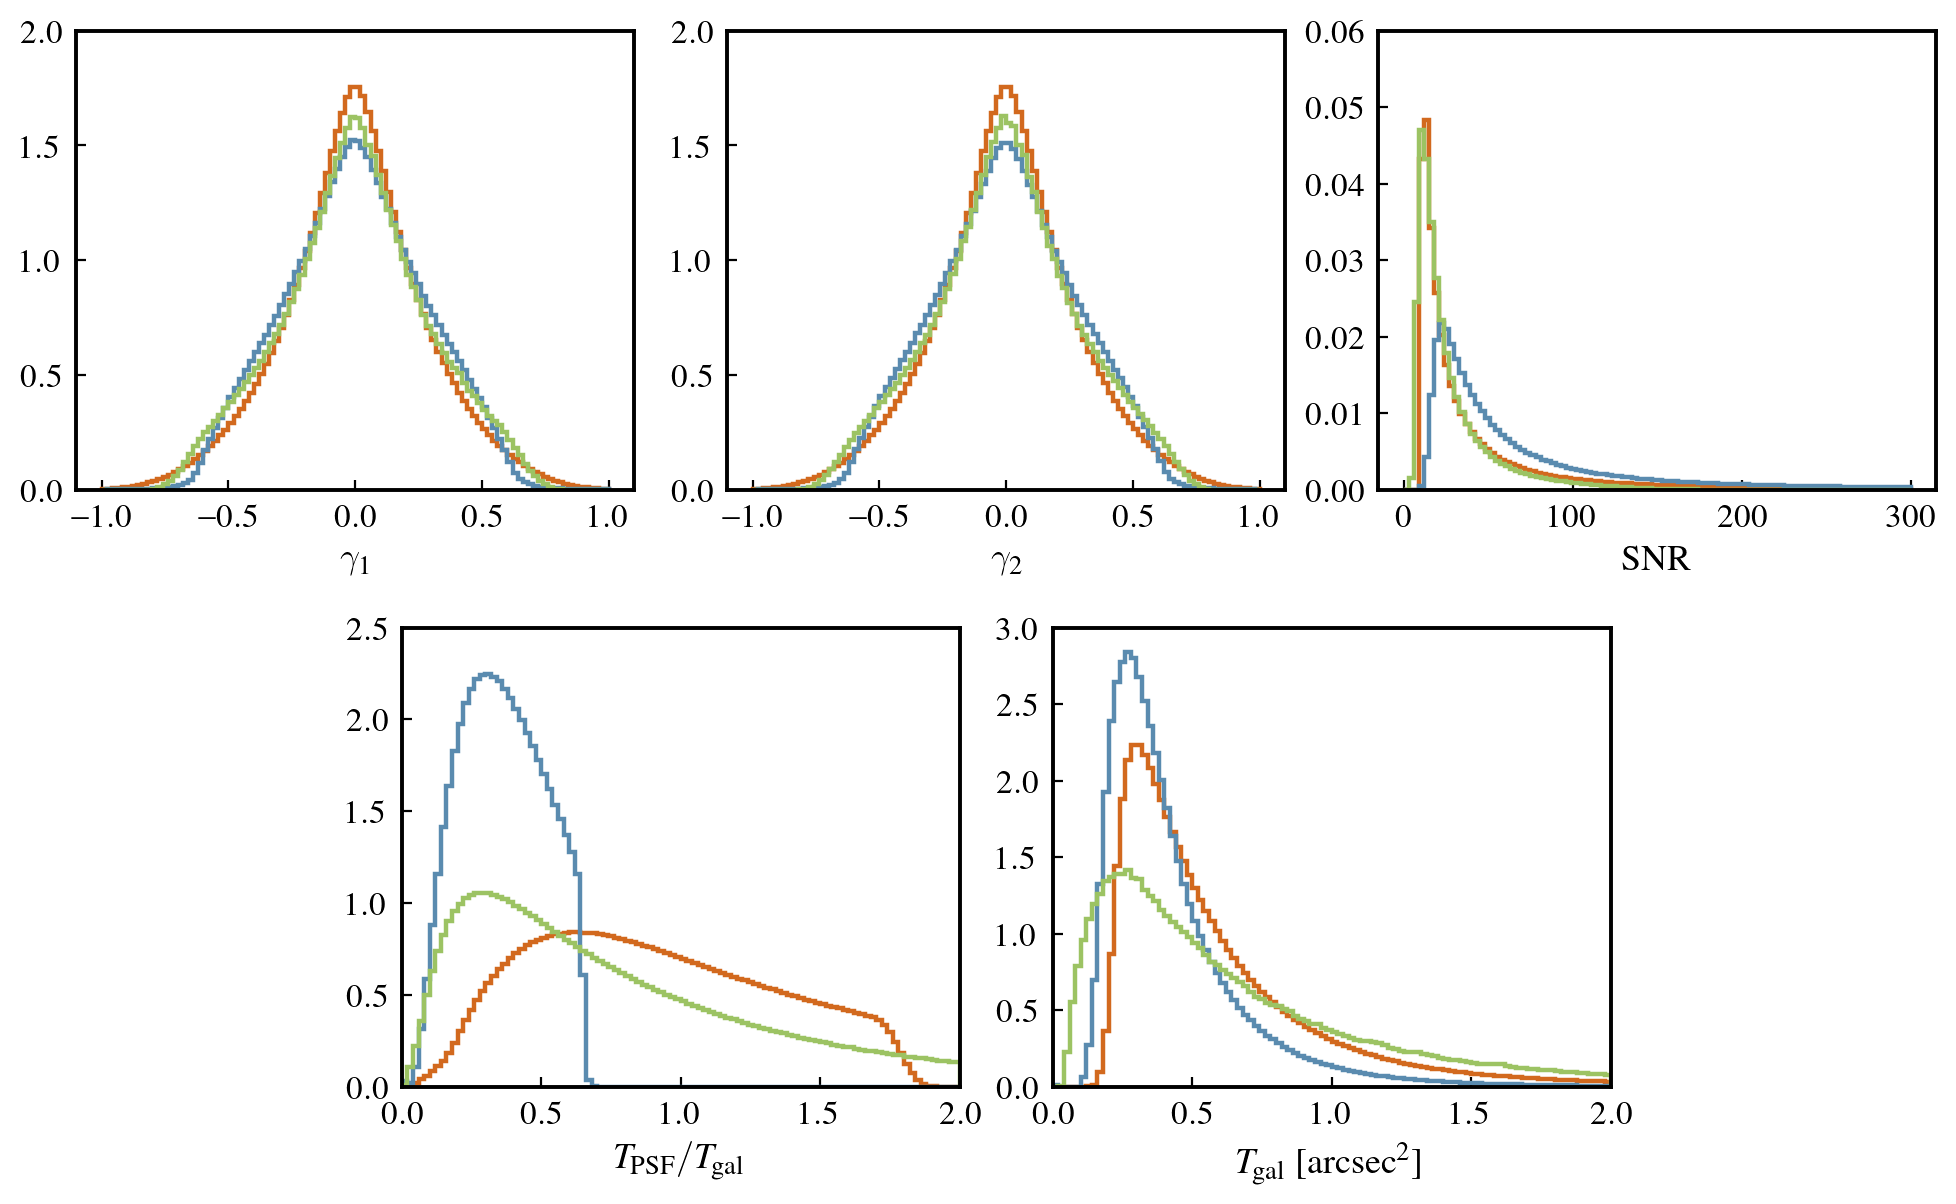

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

matplotlib.rcParams.update({'font.size': 12})

plt.clf()
fig = plt.figure(figsize=(10,6),dpi=100)
gs  = gridspec.GridSpec(2, 6, top=0.98, right=0.98, left=0.05, bottom=0.1,hspace=0.3,wspace=0.4)
ax0 = plt.subplot(gs[0,:2])
ax0.hist(des_g1,bins=100,range=[-1,1],label='DES-Y3',histtype='step',color=descol,density=True,lw=1.6)
ax0.hist(hsc_g1,bins=100,range=[-1,1],label='HSC-Y3',histtype='step',color=hsccol,density=True,lw=1.6)
ax0.hist(kids_g1,bins=100,range=[-1,1],label='KiDS-1000',histtype='step',color=kidscol,density=True,lw=1.6)
ax0.set_xlabel(r'$\gamma_{1}$',size=13)
ax0.tick_params(axis="both",which='both',direction="in")
ax0.set_ylim(0,2)
ax0.tick_params(axis='both', which='major', pad=5)
  
ax1 = plt.subplot(gs[0,2:4])
ax1.hist(des_g2,bins=100,range=[-1,1],label='DES-Y3',histtype='step',color=descol,density=True,lw=1.6)
ax1.hist(hsc_g2,bins=100,range=[-1,1],label='HSC-Y3',histtype='step',color=hsccol,density=True,lw=1.6)
ax1.hist(kids_g2,bins=100,range=[-1,1],label='KiDS-1000',histtype='step',color=kidscol,density=True,lw=1.6)
ax1.set_xlabel(r'$\gamma_{2}$',size=13)
ax1.tick_params(axis="both",which='both',direction="in")
ax1.set_ylim(0,2)
ax1.tick_params(axis='both', which='major', pad=5)
  
ax2 = plt.subplot(gs[0,4:6])
ax2.hist(des_snr,bins=100,range=[0,300],label='DES-Y3',histtype='step',color=descol,density=True,lw=1.6)
ax2.hist(hsc_snr,bins=100,range=[0,300],label='HSC-Y3',histtype='step',color=hsccol,density=True,lw=1.6)
ax2.hist(kids_snr,bins=100,range=[0,300],label='KiDS-1000',histtype='step',color=kidscol,density=True,lw=1.6)
ax2.set_xlabel(r'${\rm SNR}$',size=13)
ax2.tick_params(axis="both",which='both',direction="in")
ax2.set_ylim(0,0.06)
ax2.tick_params(axis='both', which='major', pad=5)
  
ax3 = plt.subplot(gs[1,1:3])
ax3.hist(des_psfT/des_T,bins=100,range=[0,2],label='DES-Y3',histtype='step',color=descol,density=True,lw=1.6)
ax3.hist(hsc_psfT/hsc_T,bins=100,range=[0,2],label='HSC-Y3',histtype='step',color=hsccol,density=True,lw=1.6)
ax3.hist(kids_psfT/kids_T,bins=100,range=[0,2],label='KiDS-1000',histtype='step',color=kidscol,density=True,lw=1.6)
ax3.set_xlabel(r'$T_{\rm PSF}/T_{\rm gal}$',size=13)
ax3.tick_params(axis="both",which='both',direction="in")
ax3.set_ylim(0,2.5)
ax3.set_xlim(0,2)
ax3.tick_params(axis='both', which='major', pad=5)
  
ax4 = plt.subplot(gs[1,3:5])
ax4.hist(des_T,bins=100,range=[0,2],label='DES-Y3',histtype='step',color=descol,density=True,lw=1.6)
ax4.hist(hsc_T,bins=100,range=[0,2],label='HSC-Y3',histtype='step',color=hsccol,density=True,lw=1.6)
ax4.hist(kids_T,bins=100,range=[0,2],label='KiDS-1000',histtype='step',color=kidscol,density=True,lw=1.6)
ax4.set_xlabel(r'$T_{\rm gal}\ [{\rm arcsec}^{2}]$',size=13)
ax4.tick_params(axis="both",which='both',direction="in")
ax4.set_ylim(0,3)
ax4.set_xlim(0,2)
ax4.set_yticks([0.0,0.5,1.0,1.5,2.0,2.5,3.0])
ax4.tick_params(axis='both', which='major', pad=5)
               
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(1.4)
    ax1.spines[axis].set_linewidth(1.4)
    ax2.spines[axis].set_linewidth(1.4)
    ax3.spines[axis].set_linewidth(1.4)
    ax4.spines[axis].set_linewidth(1.4)
    #ax5.spines[axis].set_linewidth(1.4)
    
#plt.savefig('shear_histograms.pdf',dpi=200)

# PSF distribution

In [4]:
# PSF catalogs for each survey can be found here at NERSC:
desy3_s = h5py.File('/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/des-y3/DES_psf_y3_catalog.hdf5','r')
hscy3_s = h5py.File('/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/hsc-y3/star/catalog/txpipe_allfield_star_nosnrcut.h5','r')
kids_s = h5py.File('/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/kids/kids1000_psf_catalog.h5','r')

<Figure size 640x480 with 0 Axes>

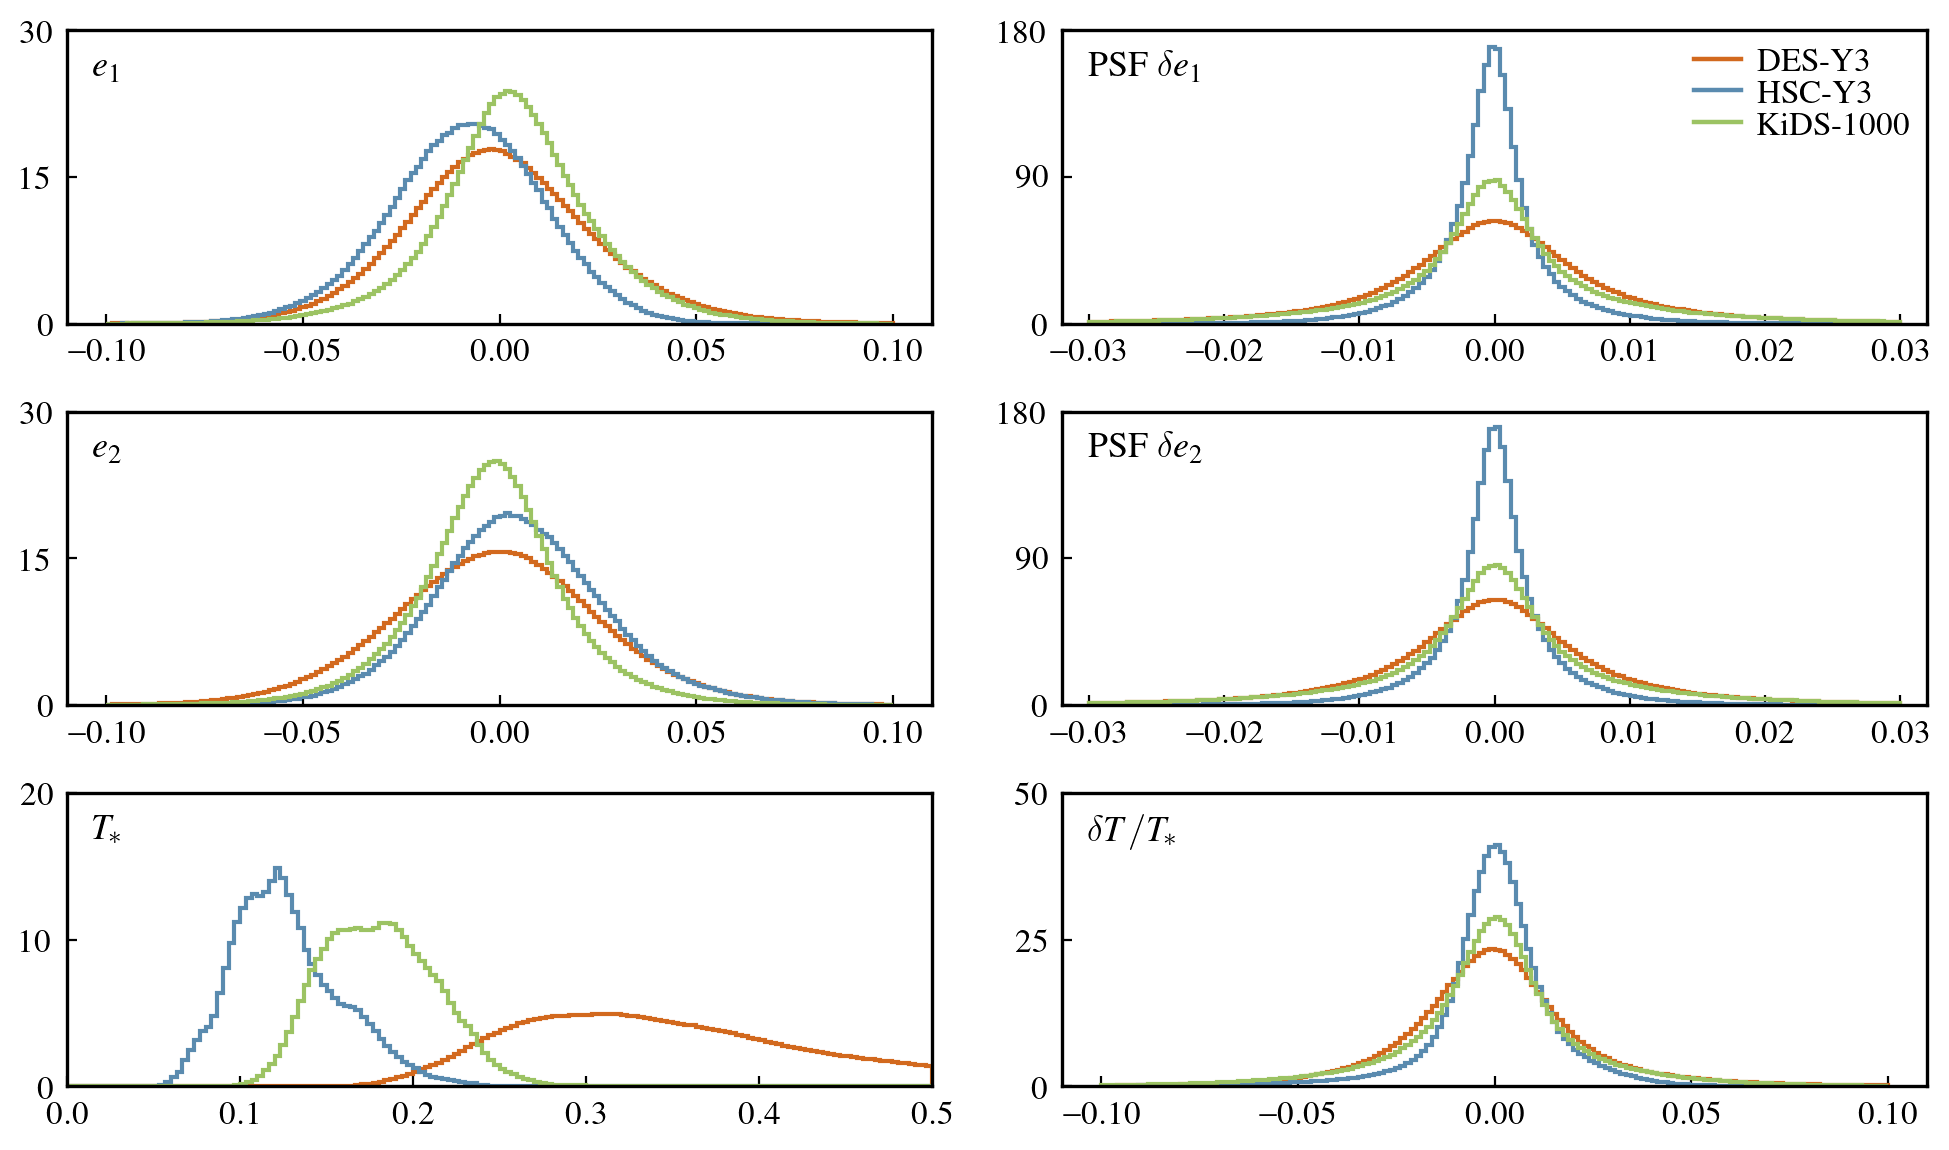

In [7]:
%matplotlib inline

matplotlib.rcParams.update({'font.size': 12})
plt.clf()
fig = plt.figure(figsize=(10,6),dpi=100)
gs  = gridspec.GridSpec(3, 2, top=0.98, right=0.98, left=0.05, bottom=0.1,hspace=0.3, wspace=0.15)

ax0 = plt.subplot(gs[0])
ax0.hist((desy3_s['stars/measured_e1'][:]),bins=150,range=[-0.1,0.1],histtype='step',color=descol,density=True,lw=1.5)
ax0.hist((hscy3_s['stars/measured_e1'][:]),bins=150,range=[-0.1,0.1],histtype='step',color=hsccol,density=True,lw=1.5)
ax0.hist((kids_s['stars/measured_e1'][:]),bins=150,range=[-0.1,0.1],histtype='step',color=kidscol,density=True,lw=1.5)

ax0.set_ylim(0,30)
ax0.text(0.03,0.93,r'$e_{1}$',transform=ax0.transAxes,ha='left',va='top',size=13)
ax0.tick_params(axis="both",which='both',direction="in")
ax0.tick_params(axis='both', which='major', pad=5)
ax0.set_yticks([0,15,30])

ax1 = plt.subplot(gs[1])
ax1.hist((desy3_s['stars/measured_e1'][:]- desy3_s['stars/model_e1'][:]),bins=150,range=[-0.03,0.03],histtype='step',color=descol,density=True,lw=1.5)
ax1.hist((hscy3_s['stars/measured_e1'][:]- hscy3_s['stars/model_e1'][:]),bins=150,range=[-0.03,0.03],histtype='step',color=hsccol,density=True,lw=1.5)
ax1.hist((kids_s['stars/measured_e1'][:]- kids_s['stars/model_e1'][:]),bins=150,range=[-0.03,0.03],histtype='step',color=kidscol,density=True,lw=1.5)
ax1.plot(np.linspace(-1000,-1001,3),color=descol,lw=1.6,label='DES-Y3')
ax1.plot(np.linspace(-1000,-1001,3),color=hsccol,lw=1.6,label='HSC-Y3')
ax1.plot(np.linspace(-1000,-1001,3),color=kidscol,lw=1.6,label='KiDS-1000')
ax1.set_xlim(-0.032,0.032)
ax1.set_ylim(0,180)
ax1.legend(frameon=False,loc = 'upper right', labelspacing=0.03,ncol=1,handletextpad=0.5,columnspacing=0.2,handlelength=1.4,borderaxespad=0.1)
ax1.text(0.03,0.93,r'${\rm PSF}\ \delta e_{1}$',transform=ax1.transAxes,ha='left',va='top',size=13)
ax1.tick_params(axis="both",which='both',direction="in")
ax1.tick_params(axis='both', which='major', pad=5)
ax1.set_yticks([0,90,180])

ax2 = plt.subplot(gs[2])
ax2.hist((desy3_s['stars/measured_e2'][:]),bins=150,range=[-0.1,0.1],histtype='step',color=descol,density=True,lw=1.5)
ax2.hist((hscy3_s['stars/measured_e2'][:]),bins=150,range=[-0.1,0.1],histtype='step',color=hsccol,density=True,lw=1.5)
ax2.hist((kids_s['stars/measured_e2'][:]),bins=150,range=[-0.1,0.1],histtype='step',color=kidscol,density=True,lw=1.5)
ax2.set_ylim(0,30)
ax2.text(0.03,0.93,r'$e_{2}$',transform=ax2.transAxes,ha='left',va='top',size=13)
ax2.tick_params(axis="both",which='both',direction="in")
ax2.tick_params(axis='both', which='major', pad=5)
ax2.set_yticks([0,15,30])

ax3 = plt.subplot(gs[3])
ax3.hist((desy3_s['stars/measured_e2'][:]- desy3_s['stars/model_e2'][:]),bins=150,range=[-0.03,0.03],histtype='step',color=descol,density=True,lw=1.5)
ax3.hist((hscy3_s['stars/measured_e2'][:]- hscy3_s['stars/model_e2'][:]),bins=150,range=[-0.03,0.03],histtype='step',color=hsccol,density=True,lw=1.5)
ax3.hist((kids_s['stars/measured_e2'][:]- kids_s['stars/model_e2'][:]),bins=150,range=[-0.03,0.03],histtype='step',color=kidscol,density=True,lw=1.5)
ax3.set_xlim(-0.032,0.032)
ax3.set_ylim(0,180)
ax3.text(0.03,0.93,r'${\rm PSF}\ \delta e_{2}$',transform=ax3.transAxes,ha='left',va='top',size=13)
ax3.tick_params(axis="both",which='both',direction="in")
ax3.tick_params(axis='both', which='major', pad=5)
ax3.set_yticks([0,90,180])

ax4 = plt.subplot(gs[4])
ax4.hist(desy3_s['stars/measured_T'][:],bins=150,range=[0,0.5],histtype='step',color=descol,density=True,lw=1.5)
ax4.hist(hscy3_s['stars/measured_T'][:],bins=150,range=[0,0.5],histtype='step',color=hsccol,density=True,lw=1.5)
ax4.hist(kids_s['stars/measured_T'][:],bins=150,range=[0,0.5],histtype='step',color=kidscol,density=True,lw=1.5)
ax4.set_xlim(0,0.5)
ax4.set_ylim(0,20)
ax4.text(0.03,0.93,r'$T_{\rm *}$',transform=ax4.transAxes,ha='left',va='top',size=13)
ax4.tick_params(axis="both",which='both',direction="in")
ax4.tick_params(axis='both', which='major', pad=5)
ax4.set_yticks([0,10,20])

ax5 = plt.subplot(gs[5])
ax5.hist((desy3_s['stars/measured_T'][:]- desy3_s['stars/model_T'][:])/desy3_s['stars/measured_T'][:],bins=150,range=[-0.1,0.1],histtype='step',color=descol,density=True,lw=1.5)
ax5.hist((hscy3_s['stars/measured_T'][:]- hscy3_s['stars/model_T'][:])/hscy3_s['stars/measured_T'][:],bins=150,range=[-0.1,0.1],histtype='step',color=hsccol,density=True,lw=1.5)
ax5.hist((kids_s['stars/measured_T'][:]- kids_s['stars/model_T'][:])/kids_s['stars/measured_T'][:],bins=150,range=[-0.1,0.1],histtype='step',color=kidscol,density=True,lw=1.5)
ax5.set_xlim(-0.11,0.11)
ax5.set_ylim(0,50)
ax5.text(0.03,0.93,r'$\delta T/ T_{\rm *}$',transform=ax5.transAxes,ha='left',va='top',size=13)
ax5.tick_params(axis="both",which='both',direction="in")
ax5.tick_params(axis='both', which='major', pad=5)
ax5.set_yticks([0,25,50])


for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(1.2)
    ax1.spines[axis].set_linewidth(1.2)
    ax2.spines[axis].set_linewidth(1.2)
    ax3.spines[axis].set_linewidth(1.2)
    ax4.spines[axis].set_linewidth(1.2)
    ax5.spines[axis].set_linewidth(1.2)


#plt.savefig('psf_histograms.pdf',dpi=200)

# Mean Shear plots

In [3]:
import pickle
file = open("desy3/TXdata/meanshear.pkl",'rb')
dic = pickle.load(file)

Text(0.5, 0, 'PSF $\\gamma_2$')

<Figure size 640x480 with 0 Axes>

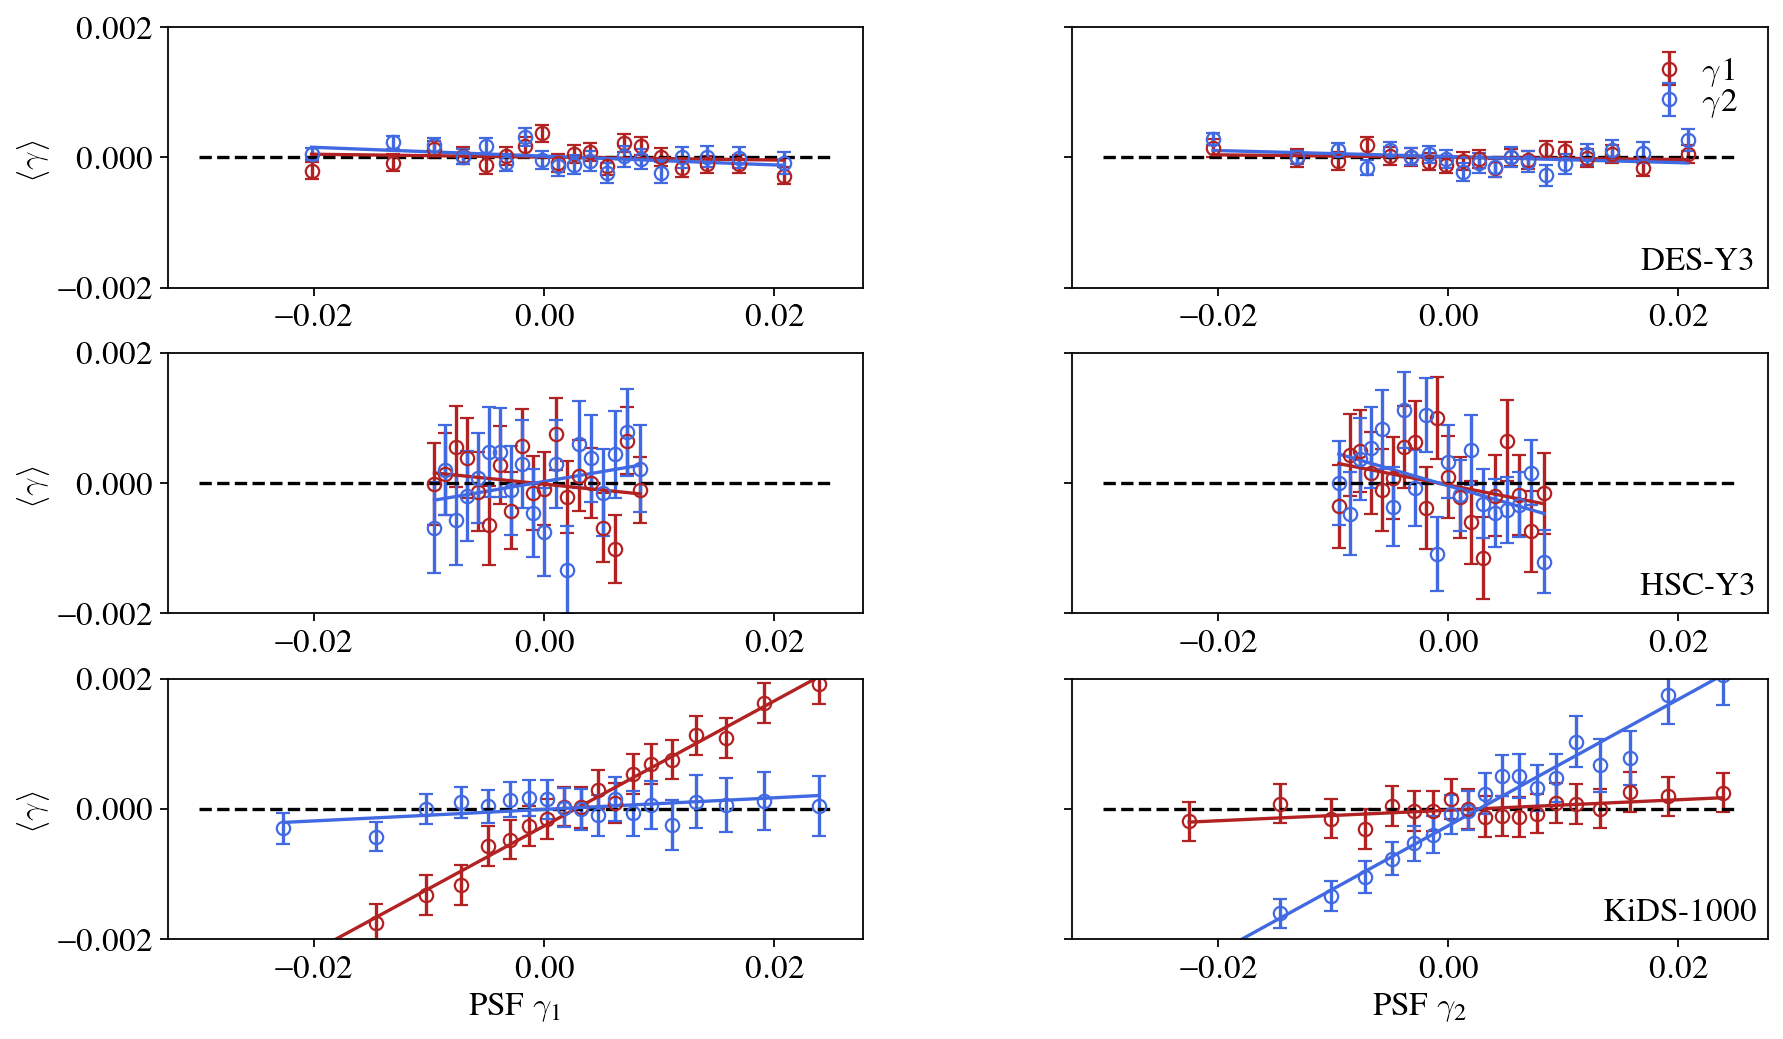

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

matplotlib.rcParams.update({'font.size': 15})

plt.clf()
fig = plt.figure(figsize=(10,6),dpi=80)

gs  = gridspec.GridSpec(3, 2, top=0.95, right=1.00, left=0.00, bottom=0.00,hspace=0.25,wspace=0.3)

d = dic['DES-Y3']['g_psfg']
ax0 = plt.subplot(gs[0])
ax0.errorbar(d['mu1'],d['meang1_psfg1']-np.mean(d['meang1_psfg1']),d['stdg1_psfg1'], color='firebrick',linestyle='None',marker='o',mfc='None',capsize=3)
ax0.errorbar(d['mu1'],d['meang2_psfg1']-np.mean(d['meang2_psfg1']),d['stdg2_psfg1'], color='royalblue',linestyle='None',marker='o',mfc='None',capsize=3)
ax0.plot(np.arange(-0.03,0.03,0.005),np.zeros(len(np.arange(-0.03,0.03,0.005))),color='black',linestyle='dashed')
ax0.plot(d['mu1'],d['fitg1_psfg1']-np.mean(d['meang1_psfg1']),color='firebrick')
ax0.plot(d['mu1'],d['fitg2_psfg1']-np.mean(d['meang2_psfg1']),color='royalblue')
ax0.set_ylim([-0.002,0.002])
ax0.set_ylabel(r'$\langle \gamma \rangle$')


ax1 = plt.subplot(gs[1])
ax1.errorbar(d['mu2'],d['meang1_psfg2']-np.mean(d['meang1_psfg2']),d['stdg1_psfg2'], color='firebrick',linestyle='None',marker='o',mfc='None',capsize=3,label=r'$\gamma1$')
ax1.errorbar(d['mu2'],d['meang2_psfg2']-np.mean(d['meang2_psfg2']),d['stdg2_psfg2'], color='royalblue',linestyle='None',marker='o',mfc='None',capsize=3,label=r'$\gamma2$')
ax1.plot(np.arange(-0.03,0.03,0.005),np.zeros(len(np.arange(-0.03,0.03,0.005))),color='black',linestyle='dashed')
ax1.plot(d['mu2'],d['fitg1_psfg2']-np.mean(d['meang1_psfg2']),color='firebrick')
ax1.plot(d['mu2'],d['fitg2_psfg2']-np.mean(d['meang2_psfg2']),color='royalblue')
ax1.yaxis.set_tick_params(labelleft=False)
ax1.legend(frameon=False,loc = 'upper right', labelspacing=0.00,ncol=1,handletextpad=0.00,columnspacing=0.2)
ax1.text(0.9, 0.1, 'DES-Y3', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
ax1.set_ylim([-0.002,0.002])

d = dic['HSC-Y3']['g_psfg']
ax2 = plt.subplot(gs[2])
ax2.errorbar(d['mu1'],d['meang1_psfg1']-np.mean(d['meang1_psfg1']),d['stdg1_psfg1'], color='firebrick',linestyle='None',marker='o',mfc='None',capsize=3)
ax2.errorbar(d['mu1'],d['meang2_psfg1']-np.mean(d['meang2_psfg1']),d['stdg2_psfg1'], color='royalblue',linestyle='None',marker='o',mfc='None',capsize=3)
ax2.plot(np.arange(-0.03,0.03,0.005),np.zeros(len(np.arange(-0.03,0.03,0.005))),color='black',linestyle='dashed')
ax2.plot(d['mu1'],d['fitg1_psfg1']-np.mean(d['meang1_psfg1']),color='firebrick')
ax2.plot(d['mu1'],d['fitg2_psfg1']-np.mean(d['meang2_psfg1']),color='royalblue')
ax2.set_ylim([-0.002,0.002])
ax2.set_ylabel(r'$\langle \gamma \rangle$')
ax2.set_ylim([-0.002,0.002])

ax3 = plt.subplot(gs[3])
ax3.errorbar(d['mu2'],d['meang1_psfg2']-np.mean(d['meang1_psfg2']),d['stdg1_psfg2'], color='firebrick',linestyle='None',marker='o',mfc='None',capsize=3)
ax3.errorbar(d['mu2'],d['meang2_psfg2']-np.mean(d['meang2_psfg2']),d['stdg2_psfg2'], color='royalblue',linestyle='None',marker='o',mfc='None',capsize=3)
ax3.plot(np.arange(-0.03,0.03,0.005),np.zeros(len(np.arange(-0.03,0.03,0.005))),color='black',linestyle='dashed')
ax3.plot(d['mu2'],d['fitg1_psfg2']-np.mean(d['meang1_psfg2']),color='firebrick')
ax3.plot(d['mu2'],d['fitg2_psfg2']-np.mean(d['meang2_psfg2']),color='royalblue')
ax3.set_ylim([-0.002,0.002])
ax3.yaxis.set_tick_params(labelleft=False)
ax3.text(0.9, 0.1, 'HSC-Y3', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)

d = dic['KiDS-1000']['g_psfg']
ax4 = plt.subplot(gs[4])
ax4.errorbar(d['mu1'],d['meang1_psfg1']-np.mean(d['meang1_psfg1']),d['stdg1_psfg1'], color='firebrick',linestyle='None',marker='o',mfc='None',capsize=3)
ax4.errorbar(d['mu1'],d['meang2_psfg1']-np.mean(d['meang2_psfg1']),d['stdg2_psfg1'], color='royalblue',linestyle='None',marker='o',mfc='None',capsize=3)
ax4.plot(np.arange(-0.03,0.03,0.005),np.zeros(len(np.arange(-0.03,0.03,0.005))),color='black',linestyle='dashed')
ax4.plot(d['mu1'],d['fitg1_psfg1']-np.mean(d['meang1_psfg1']),color='firebrick')
ax4.plot(d['mu1'],d['fitg2_psfg1']-np.mean(d['meang2_psfg1']),color='royalblue')
ax4.set_ylim([-0.002,0.002])
ax4.set_ylabel(r'$\langle \gamma \rangle$')
ax4.set_xlabel(rf'PSF $\gamma_1$')

ax5 = plt.subplot(gs[5])
ax5.errorbar(d['mu2'],d['meang1_psfg2']-np.mean(d['meang1_psfg2']),d['stdg1_psfg2'], color='firebrick',linestyle='None',marker='o',mfc='None',capsize=3)
ax5.errorbar(d['mu2'],d['meang2_psfg2']-np.mean(d['meang2_psfg2']),d['stdg2_psfg2'], color='royalblue',linestyle='None',marker='o',mfc='None',capsize=3)
ax5.plot(np.arange(-0.03,0.03,0.005),np.zeros(len(np.arange(-0.03,0.03,0.005))),color='black',linestyle='dashed')
ax5.plot(d['mu2'],d['fitg1_psfg2']-np.mean(d['meang1_psfg2']),color='firebrick')
ax5.plot(d['mu2'],d['fitg2_psfg2']-np.mean(d['meang2_psfg2']),color='royalblue')
ax5.yaxis.set_tick_params(labelleft=False)
ax5.text(0.875, 0.1, 'KiDS-1000', horizontalalignment='center', verticalalignment='center', transform=ax5.transAxes)
ax5.set_ylim([-0.002,0.002])
ax5.set_xlabel(rf'PSF $\gamma_2$')

#fig.savefig('plots/comp_psfg.pdf',bbox_inches='tight')

Text(0.875, 0.1, 'KiDS-1000')

<Figure size 640x480 with 0 Axes>

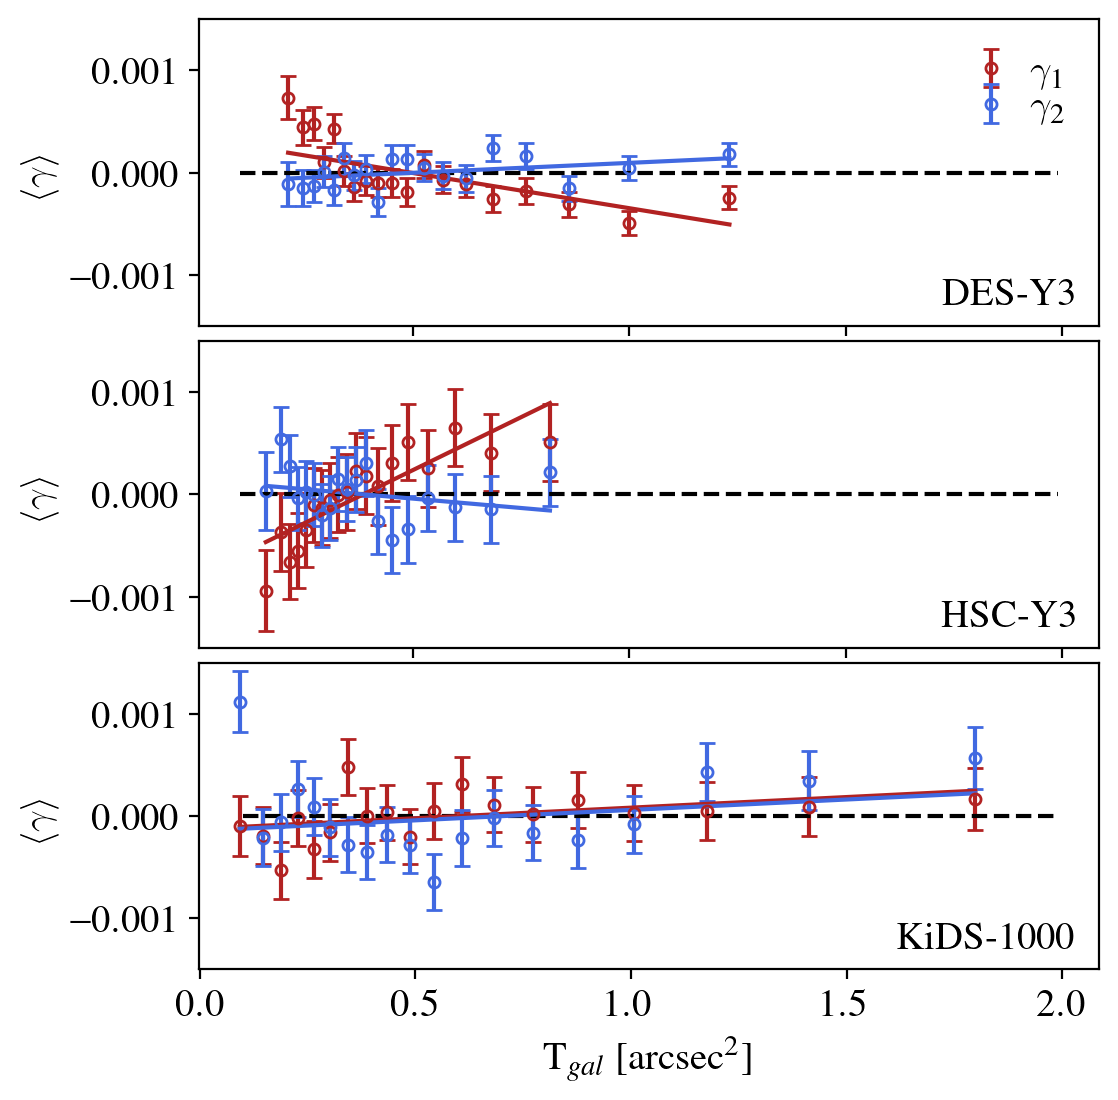

In [5]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

plt.clf()
fig = plt.figure(figsize=(4.5,5),dpi=100)
gs  = gridspec.GridSpec(3, 1, top=0.95, right=1.00, left=0.00, bottom=0.00,hspace=0.05,wspace=0.15)

d = dic['DES-Y3']['g_T']
ax0 = plt.subplot(gs[0])
ax0.errorbar(d['mu'],d['meang1']-np.mean(d['meang1']),d['stdg1'], color='firebrick',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3,label=r'$\gamma_1$')
ax0.errorbar(d['mu'],d['meang2']-np.mean(d['meang2']),d['stdg2'], color='royalblue',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3,label=r'$\gamma_2$')
ax0.plot(np.arange(0.1,2,0.01),np.zeros(len(np.arange(0.1,2,0.01))),color='black',linestyle='dashed')
ax0.plot(d['mu'],d['fitg1']-np.mean(d['meang1']),color='firebrick')
ax0.plot(d['mu'],d['fitg2']-np.mean(d['meang2']),color='royalblue')
ax0.set_ylabel(r'$\langle \gamma \rangle$')
ax0.set_ylim([-0.0015,0.0015])
ax0.set_xlabel(r'T$_{gal}$')
ax0.legend(frameon=False,loc = 'upper right', labelspacing=0.00,ncol=1,handletextpad=0.00,columnspacing=0.2)
ax0.text(0.9, 0.1, 'DES-Y3', horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)

d = dic['HSC-Y3']['g_T']
ax1 = plt.subplot(gs[1])
ax1.errorbar(d['mu'],d['meang1']-np.mean(d['meang1']),d['stdg1'], color='firebrick',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3)
ax1.errorbar(d['mu'],d['meang2']-np.mean(d['meang2']),d['stdg2'], color='royalblue',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3)
ax1.plot(np.arange(0.1,2,0.01),np.zeros(len(np.arange(0.1,2,0.01))),color='black',linestyle='dashed')
ax1.plot(d['mu'],d['fitg1']-np.mean(d['meang1']),color='firebrick')
ax1.plot(d['mu'],d['fitg2']-np.mean(d['meang2']),color='royalblue')
ax1.set_ylim([-0.0015,0.0015])
ax1.set_ylabel(r'$\langle \gamma \rangle$')
ax1.text(0.9, 0.1, 'HSC-Y3', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

d = dic['KiDS-1000']['g_T']
ax2 = plt.subplot(gs[2])
ax2.errorbar(d['mu'],d['meang1']-np.mean(d['meang1']),d['stdg1'], color='firebrick',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3)
ax2.errorbar(d['mu'],d['meang2']-np.mean(d['meang2']),d['stdg2'], color='royalblue',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3)
ax2.plot(np.arange(0.1,2,0.01),np.zeros(len(np.arange(0.1,2,0.01))),color='black',linestyle='dashed')
ax2.plot(d['mu'],d['fitg1']-np.mean(d['meang1']),color='firebrick')
ax2.plot(d['mu'],d['fitg2']-np.mean(d['meang2']),color='royalblue')
ax2.set_ylim([-0.0015,0.0015])
ax2.set_ylabel(r'$\langle \gamma \rangle$')
ax2.set_xlabel(r'T$_{gal}$ [arcsec$^2$]')
ax2.text(0.875, 0.1, 'KiDS-1000', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)


Text(0.875, 0.1, 'KiDS-1000')

<Figure size 640x480 with 0 Axes>

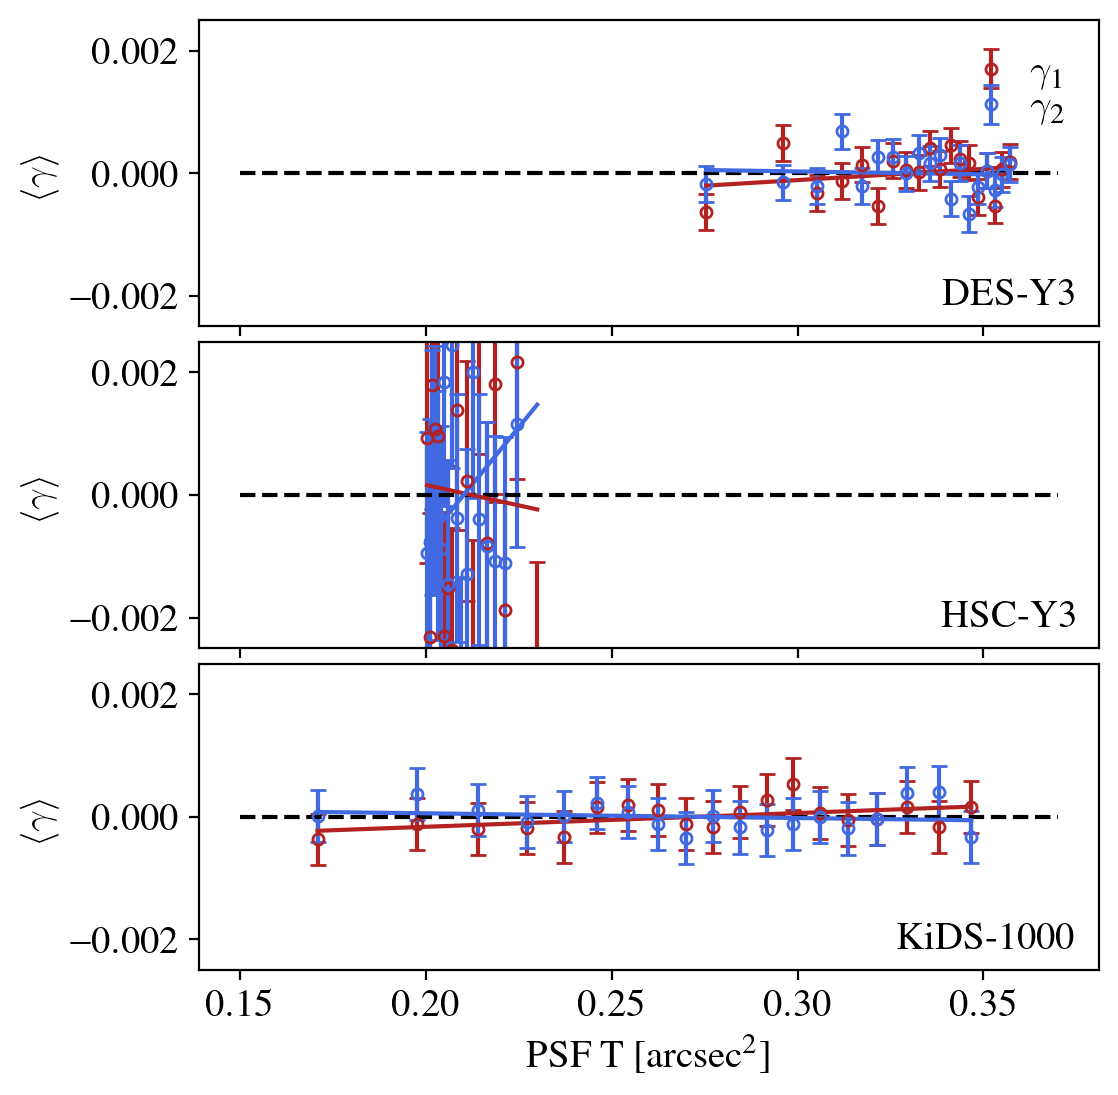

In [6]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

plt.clf()
fig = plt.figure(figsize=(4.5,5),dpi=100)
gs  = gridspec.GridSpec(3, 1, top=0.95, right=1.00, left=0.00, bottom=0.00,hspace=0.05,wspace=0.15)

d = dic['DES-Y3']['g_psfT']
ax0 = plt.subplot(gs[0])
ax0.errorbar(d['mu'],d['meang1']-np.mean(d['meang1']),d['stdg1'], color='firebrick',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3,label=r'$\gamma_1$')
ax0.errorbar(d['mu'],d['meang2']-np.mean(d['meang2']),d['stdg2'], color='royalblue',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3,label=r'$\gamma_2$')
ax0.plot(np.arange(0.15,0.38,0.01),np.zeros(len(np.arange(0.15,0.38,0.01))),color='black',linestyle='dashed')
ax0.plot(d['mu'],d['fitg1']-np.mean(d['meang1']),color='firebrick')
ax0.plot(d['mu'],d['fitg2']-np.mean(d['meang2']),color='royalblue')
ax0.set_ylim([-0.0025,0.0025])
ax0.set_ylabel(r'$\langle \gamma \rangle$')
ax0.legend(frameon=False,loc = 'upper right', labelspacing=0.00,ncol=1,handletextpad=0.00,columnspacing=0.2)
ax0.text(0.9, 0.1, 'DES-Y3', horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)

d = dic['HSC-Y3']['g_psfT']
ax1 = plt.subplot(gs[1])
ax1.errorbar(d['mu'],d['meang1']-np.mean(d['meang1']),d['stdg1'], color='firebrick',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3)
ax1.errorbar(d['mu'],d['meang2']-np.mean(d['meang2']),d['stdg2'], color='royalblue',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3)
ax1.plot(np.arange(0.15,0.38,0.01),np.zeros(len(np.arange(0.15,0.38,0.01))),color='black',linestyle='dashed')
ax1.plot(d['mu'],d['fitg1']-np.mean(d['meang1']),color='firebrick')
ax1.plot(d['mu'],d['fitg2']-np.mean(d['meang2']),color='royalblue')
ax1.set_ylim([-0.0025,0.0025])
ax1.set_ylabel(r'$\langle \gamma \rangle$')
ax1.text(0.9, 0.1, 'HSC-Y3', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

d = dic['KiDS-1000']['g_psfT']
ax2 = plt.subplot(gs[2])
ax2.errorbar(d['mu'],d['meang1']-np.mean(d['meang1']),d['stdg1'], color='firebrick',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3)
ax2.errorbar(d['mu'],d['meang2']-np.mean(d['meang2']),d['stdg2'], color='royalblue',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3)
ax2.plot(np.arange(0.15,0.38,0.01),np.zeros(len(np.arange(0.15,0.38,0.01))),color='black',linestyle='dashed')
ax2.plot(d['mu'],d['fitg1']-np.mean(d['meang1']),color='firebrick')
ax2.plot(d['mu'],d['fitg2']-np.mean(d['meang2']),color='royalblue')
ax2.set_ylim([-0.0025,0.0025])
ax2.set_ylabel(r'$\langle \gamma \rangle$')
ax2.set_xlabel(r'PSF T [arcsec$^2$]')
ax2.text(0.875, 0.1, 'KiDS-1000', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)

Text(0.875, 0.1, 'KiDS-1000')

<Figure size 640x480 with 0 Axes>

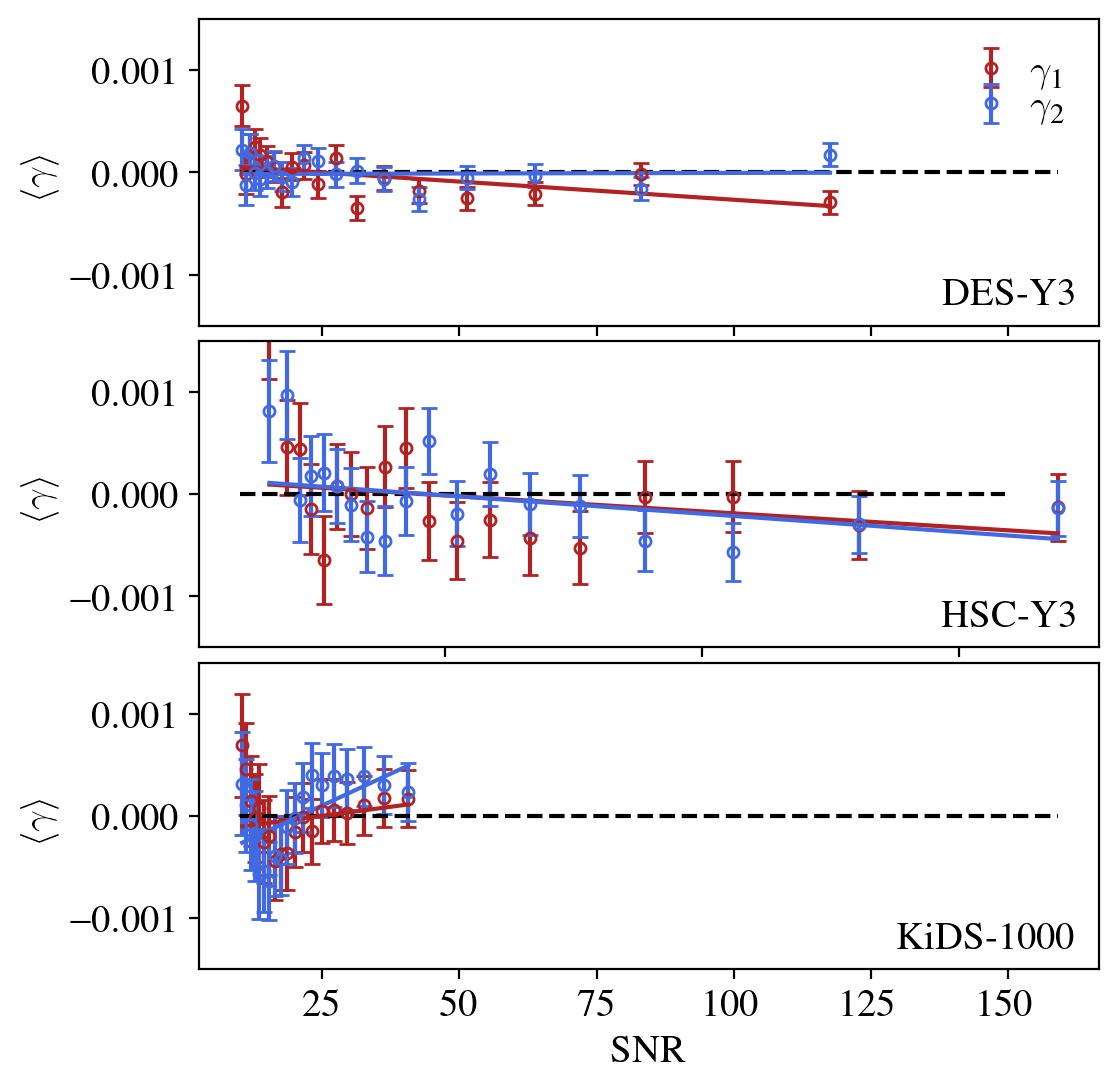

In [8]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

plt.clf()
fig = plt.figure(figsize=(4.5,5),dpi=100)
gs  = gridspec.GridSpec(3, 1, top=0.95, right=1.00, left=0.00, bottom=0.00,hspace=0.05,wspace=0.15)

d = dic['DES-Y3']['g_snr']
ax0 = plt.subplot(gs[0])
ax0.errorbar(d['mu'],d['meang1']-np.mean(d['meang1']),d['stdg1'], color='firebrick',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3,label=r'$\gamma_1$')
ax0.errorbar(d['mu'],d['meang2']-np.mean(d['meang2']),d['stdg2'], color='royalblue',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3,label=r'$\gamma_2$')
ax0.plot(range(10,160),np.zeros(len(range(10,160))),color='black', linestyle='dashed')
ax0.plot(d['mu'],d['fitg1']-np.mean(d['meang1']),color='firebrick')
ax0.plot(d['mu'],d['fitg2']-np.mean(d['meang2']),color='royalblue')
ax0.set_ylim([-0.0015,0.0015])
ax0.set_ylabel(r'$\langle \gamma \rangle$')
ax0.legend(frameon=False,loc = 'upper right', labelspacing=0.00,ncol=1,handletextpad=0.00,columnspacing=0.2)
ax0.text(0.9, 0.1, 'DES-Y3', horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)

d = dic['HSC-Y3']['g_snr']
ax1 = plt.subplot(gs[1])
ax1.errorbar(d['mu'],d['meang1']-np.mean(d['meang1']),d['stdg1'], color='firebrick',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3)
ax1.errorbar(d['mu'],d['meang2']-np.mean(d['meang2']),d['stdg2'], color='royalblue',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3)
ax1.plot(range(10,160),np.zeros(len(range(10,160))),color='black', linestyle='dashed')
ax1.plot(d['mu'],d['fitg1']-np.mean(d['meang1']),color='firebrick')
ax1.plot(d['mu'],d['fitg2']-np.mean(d['meang2']),color='royalblue')
ax1.set_ylim([-0.0015,0.0015])
ax1.set_ylabel(r'$\langle \gamma \rangle$')
ax1.text(0.9, 0.1, 'HSC-Y3', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

d = dic['KiDS-1000']['g_snr']
ax2 = plt.subplot(gs[2])
ax2.errorbar(d['mu'],d['meang1']-np.mean(d['meang1']),d['stdg1'], color='firebrick',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3)
ax2.errorbar(d['mu'],d['meang2']-np.mean(d['meang2']),d['stdg2'], color='royalblue',linestyle='None',marker='o',mfc='None',markersize=4,capsize=3)
ax2.plot(range(10,160),np.zeros(len(range(10,160))),color='black', linestyle='dashed')
ax2.plot(d['mu'],d['fitg1']-np.mean(d['meang1']),color='firebrick')
ax2.plot(d['mu'],d['fitg2']-np.mean(d['meang2']),color='royalblue')
ax2.set_ylim([-0.0015,0.0015])
ax2.set_ylabel(r'$\langle \gamma \rangle$')
ax2.set_xlabel('SNR')
ax2.text(0.875, 0.1, 'KiDS-1000', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)

# $\rho$ stats

In [2]:
desy3rowe = h5py.File('/pscratch/sd/j/jjeffers/temp/TXPipe/data/desy3/outputs/rowe_stats.hdf5','r')
hscy3rowe = h5py.File('/pscratch/sd/j/jjeffers/temp/TXPipe/data/hsc-y3/outputs/shearsys/rowe_stats.hdf5','r')
kidsrowe = h5py.File('/pscratch/sd/j/jjeffers/temp/TXPipe/data/kids/outputs/meansubperfield/rowe_stats.hdf5','r')

<Figure size 640x480 with 0 Axes>

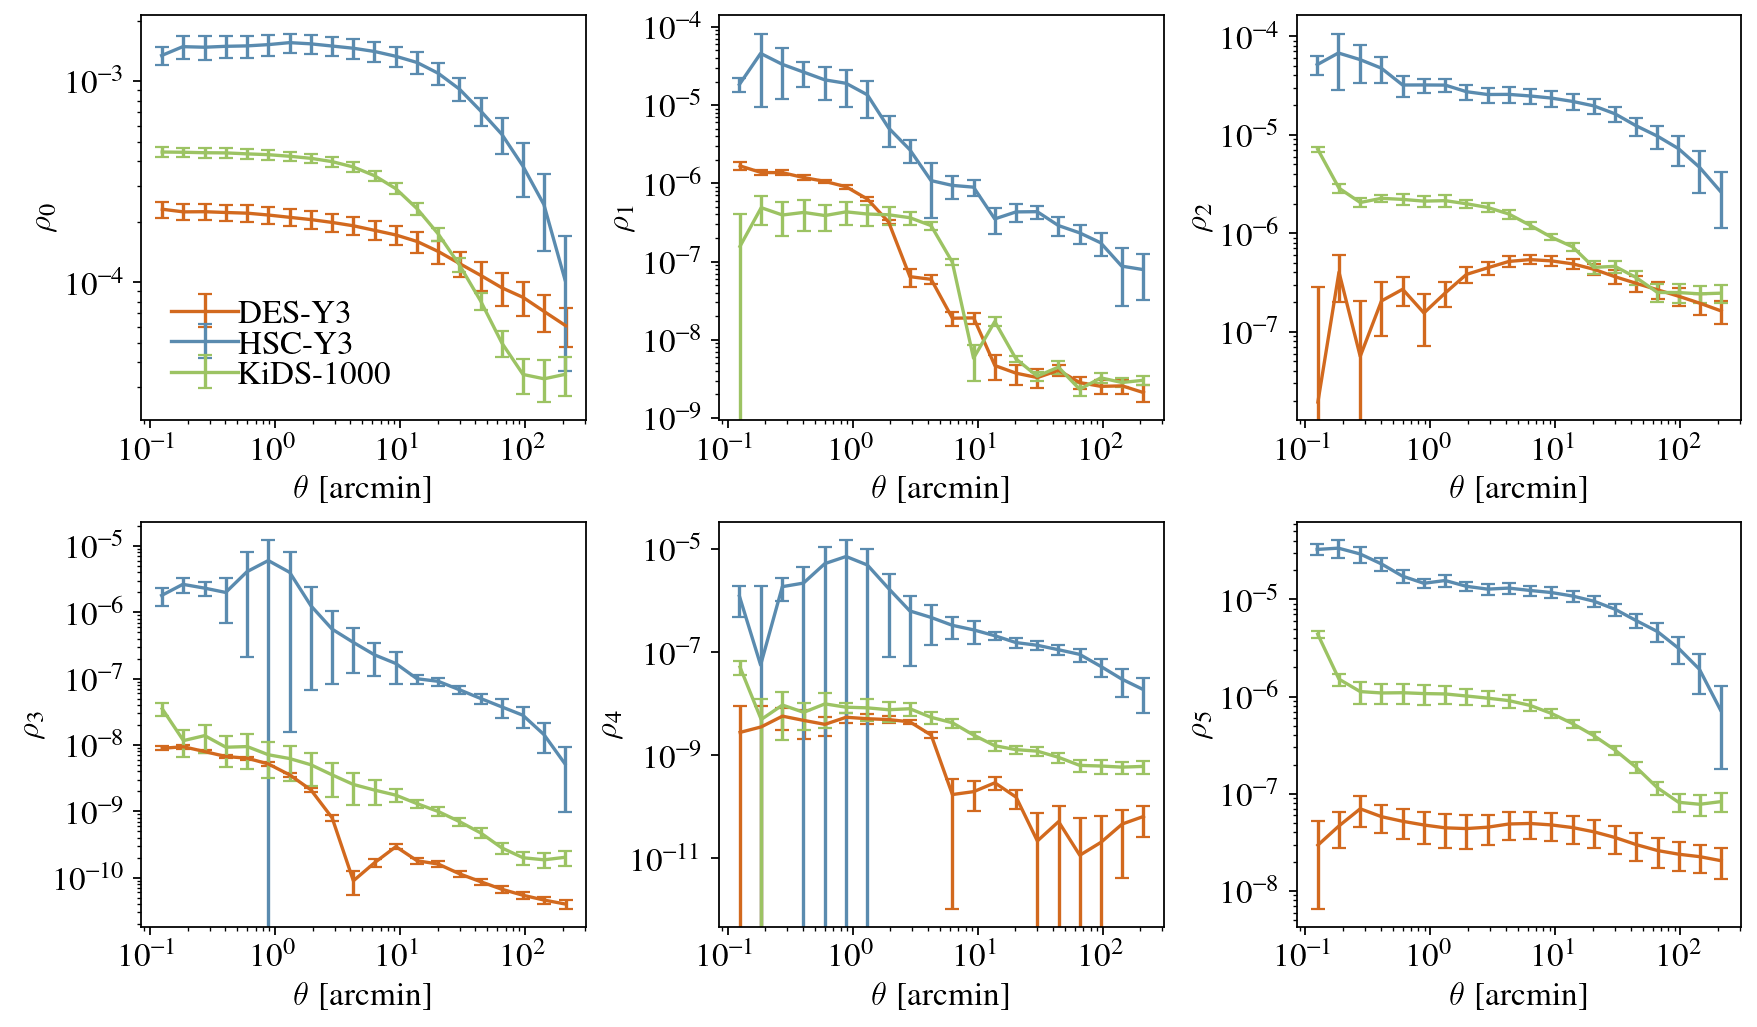

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

matplotlib.rcParams.update({'font.size': 15})

plt.clf()
fig = plt.figure(figsize=(10,6),dpi=80)
gs  = gridspec.GridSpec(2, 3, top=0.95, right=1.00, left=0.00, bottom=0.00,hspace=0.25,wspace=0.3)
#gs  = gridspec.GridSpec(2, 3, top=0.95, right=1.00, left=0.00, bottom=0.00,hspace=0.25,wspace=0.15)
ax0 = plt.subplot(gs[0])
i = 0
ax0.errorbar(np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    np.abs(np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=descol,label='DES-Y3')
ax0.errorbar(np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    0.5*np.abs(np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    0.5*np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=hsccol,label='HSC-Y3')
ax0.errorbar(np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    np.abs(np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=kidscol,label='KiDS-1000')
ax0.set_xscale('log')
ax0.set_ylabel(rf'$\rho_{i}$')
ax0.set_xlabel(rf'$\theta$ [arcmin]')
ax0.set_yscale('log')
ax0.legend(frameon=False,loc = 'lower left', labelspacing=0.00,ncol=1,handletextpad=0.00,columnspacing=0.2)


i = 1

ax1 = plt.subplot(gs[1])
ax1.errorbar(np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    np.abs(np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=descol,label='DES-Y3')
ax1.errorbar(np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    0.5*np.abs(np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    0.5*np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=hsccol,label='HSC-Y3')
ax1.errorbar(np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    np.abs(np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=kidscol,label='KiDS-1000')
ax1.set_xscale('log')
#plt.ylim([9e-5, 2.5e-3])
ax1.set_yscale('log')
ax1.set_ylabel(rf'$\rho_{i}$')
ax1.set_xlabel(rf'$\theta$ [arcmin]')

i = 2
ax2 = plt.subplot(gs[2])
ax2.errorbar(np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    np.abs(np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=descol,label='DES-Y3')
ax2.errorbar(np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    0.5*np.abs(np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    0.5*np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=hsccol,label='HSC-Y3')
ax2.errorbar(np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    np.abs(np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=kidscol,label='KiDS-1000')
ax2.set_xscale('log')
ax2.set_ylabel(rf'$\rho_{i}$')
ax2.set_xlabel(rf'$\theta$ [arcmin]')
ax2.set_yscale('log')

i = 3
ax3 = plt.subplot(gs[3])
ax3.errorbar(np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    np.abs(np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=descol,label='DES-Y3')
ax3.errorbar(np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    0.5*np.abs(np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    0.5*np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=hsccol,label='HSC-Y3')
ax3.errorbar(np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    np.abs(np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=kidscol,label='KiDS-1000')
ax3.set_xscale('log')
ax3.set_ylabel(rf'$\rho_{i}$')
ax3.set_xlabel(rf'$\theta$ [arcmin]')
ax3.set_yscale('log')

i = 4
ax4 = plt.subplot(gs[4])
ax4.errorbar(np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    np.abs(np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=descol,label='DES-Y3')
ax4.errorbar(np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    0.5*np.abs(np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    0.5*np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=hsccol,label='HSC-Y3')
ax4.errorbar(np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    np.abs(np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=kidscol,label='KiDS-1000')
ax4.set_xscale('log')
ax4.set_ylabel(rf'$\rho_{i}$')
ax4.set_xlabel(rf'$\theta$ [arcmin]')
ax4.set_yscale('log')

i = 5
ax5 = plt.subplot(gs[5])
ax5.errorbar(np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    np.abs(np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    np.array(desy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=descol,label='DES-Y3')
ax5.errorbar(np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    0.5*np.abs(np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    0.5*np.array(hscy3rowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=hsccol,label='HSC-Y3')
ax5.errorbar(np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/theta']),
                    np.abs(np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_plus'])),
                    np.array(kidsrowe[f'rowe_statistics/rowe_{i}_PSF-reserved/xi_err']),capsize=3,color=kidscol,label='KiDS-1000')

ax5.set_xscale('log')
ax5.set_ylabel(rf'$\rho_{i}$')
ax5.set_xlabel(rf'$\theta$ [arcmin]')
ax5.set_yscale('log')

plt.savefig('rowes.pdf',bbox_inches='tight')


# $\tau$ stats

In [38]:
import h5py
filename = "/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/desy3/TXdata/tau_stats.hdf5"

des={}
with h5py.File("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/desy3/TXdata/tau_stats.hdf5", "r") as f:
    print(f['tau_statistics']['bestfits_PSF-reserved'].keys())
    des['cov']  = f['tau_statistics']['tau_PSF-reserved']['cov'][:]
    des['tht']  = f['tau_statistics']['tau_PSF-reserved']['theta'][:]
    des['tau0'] = f['tau_statistics']['tau_PSF-reserved']['tau0'][:]
    des['tau2'] = f['tau_statistics']['tau_PSF-reserved']['tau2'][:]
    des['tau5'] = f['tau_statistics']['tau_PSF-reserved']['tau5'][:]
    
kids={}
with h5py.File("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/KiDS/TXdata/tau_stats.hdf5", "r") as f:
    print(f['tau_statistics']['bestfits_PSF-reserved'].keys())
    kids['cov']  = f['tau_statistics']['tau_PSF-reserved']['cov'][:]
    kids['tht']  = f['tau_statistics']['tau_PSF-reserved']['theta'][:]
    kids['tau0'] = f['tau_statistics']['tau_PSF-reserved']['tau0'][:]
    kids['tau2'] = f['tau_statistics']['tau_PSF-reserved']['tau2'][:]
    kids['tau5'] = f['tau_statistics']['tau_PSF-reserved']['tau5'][:]

hsc={}
with h5py.File("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/TXdata/tau_stats.hdf5", "r") as f:
    print(f['tau_statistics']['bestfits_PSF-reserved'].keys())
    hsc['cov']  = f['tau_statistics']['tau_PSF-reserved']['cov'][:]
    hsc['tht']  = f['tau_statistics']['tau_PSF-reserved']['theta'][:]
    hsc['tau0'] = f['tau_statistics']['tau_PSF-reserved']['tau0'][:]
    hsc['tau2'] = f['tau_statistics']['tau_PSF-reserved']['tau2'][:]
    hsc['tau5'] = f['tau_statistics']['tau_PSF-reserved']['tau5'][:]


<KeysViewHDF5 ['alpha', 'alpha_err', 'beta', 'beta_err', 'eta', 'eta_err']>
<KeysViewHDF5 ['alpha', 'alpha_err', 'beta', 'beta_err', 'eta', 'eta_err']>
<KeysViewHDF5 ['alpha', 'alpha_err', 'beta', 'beta_err', 'eta', 'eta_err']>


<Figure size 432x288 with 0 Axes>

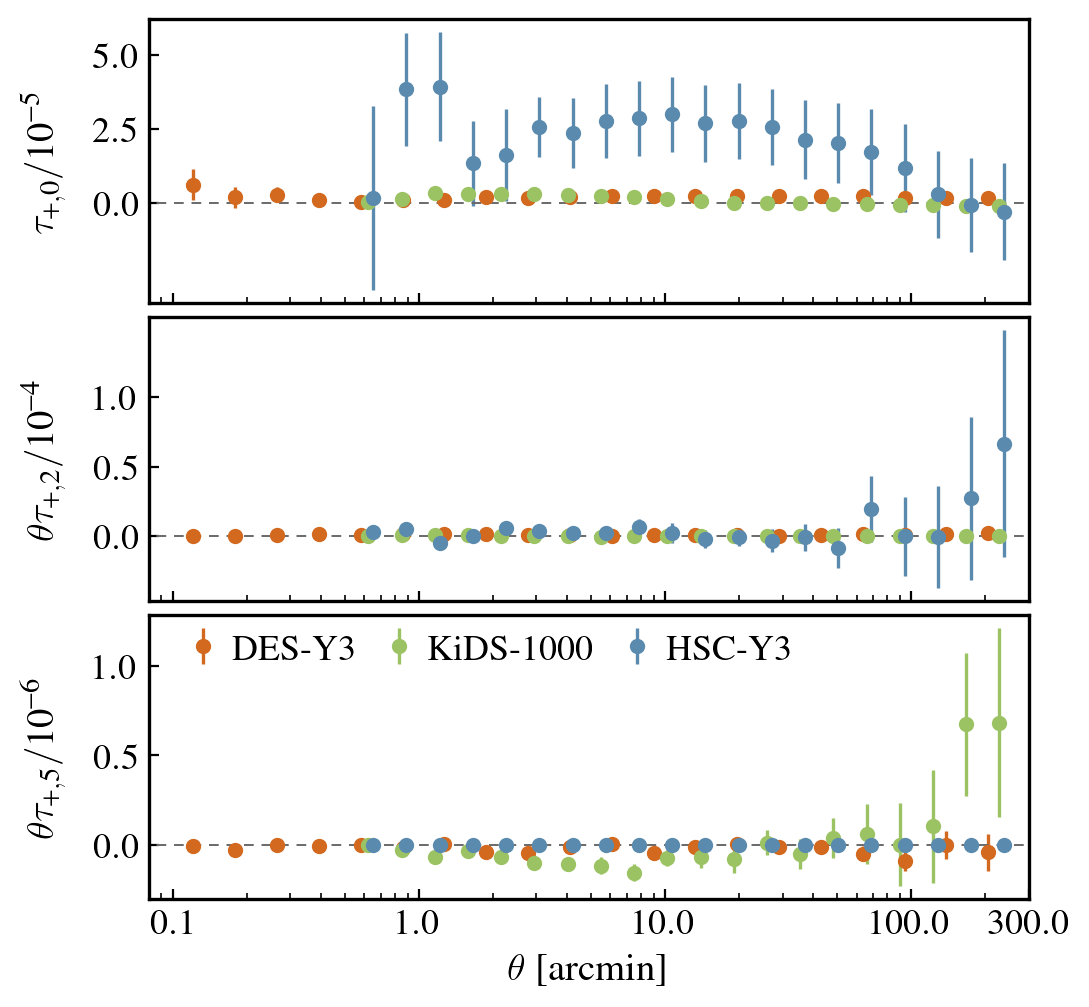

In [61]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 13})

# CHECK COVARIANCE INDICES AGAIN

plt.clf()
fig = plt.figure(figsize=(5,4),dpi=100)

gs  = gridspec.GridSpec(3, 1, top=0.98, right=0.96, left=0.16, bottom=0.1,hspace=0.05,wspace=0.15)

ax0 = plt.subplot(gs[0])
ax0.set_ylabel(r'$\tau_{+,0}/10^{-5}$',size=14,labelpad=10)
ax0.errorbar(10**(np.log10(des['tht'])+0.00) ,des['tau0']/1e-5   ,yerr=(np.diag(des['cov'])**0.5)[:20]/1e-5     ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=descol)
ax0.errorbar(10**(np.log10(kids['tht'])+0.02),kids['tau0']/1e-5  ,yerr=(np.diag(kids['cov'])**0.5)[:20]/1e-5    ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=kidscol)
ax0.errorbar(10**(np.log10(hsc['tht'])+0.04) ,hsc['tau0']/1e-5   ,yerr=(np.diag(hsc['cov'])**0.5)[:20]/1e-5 ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=hsccol)

ax0.semilogx(np.arange(300),np.zeros(300),color='dimgray',ls='--',lw=0.7,dashes=(5,4))
ax0.tick_params(axis="both",which='both',direction="in")
plt.setp(ax0.get_xticklabels(), visible=False)
#ax0.tick_params(axis="x",direction="in")
ax0.set_xlim(0.08,300)
ax0.set_yticks([0.0,2.5,5.0])

ax1 = plt.subplot(gs[1])

ax1.set_ylabel(r'$\theta\tau_{+,2}/10^{-4}$',size=14,labelpad=10)
ax1.errorbar(10**(np.log10(des['tht'])+0.00) ,des['tht']*des['tau2']/1e-4  ,yerr=des['tht']*(np.diag(des['cov'])**0.5)[40:60]/1e-4  ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=descol)
ax1.errorbar(10**(np.log10(kids['tht'])+0.02),kids['tht']*kids['tau2']/1e-4,yerr=kids['tht']*(np.diag(kids['cov'])**0.5)[20:40]/1e-4,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=kidscol)
ax1.errorbar(10**(np.log10(hsc['tht'])+0.04) ,hsc['tht']*hsc['tau2']/1e-4  ,yerr=hsc['tht']*(np.diag(hsc['cov'])**0.5)[20:40]/1e-4  ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=hsccol)

ax1.semilogx(np.arange(300),np.zeros(300),color='dimgray',ls='--',lw=0.7,dashes=(5,4))
ax1.tick_params(axis="both",which='both',direction="in")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_xlim(0.08,300)
ax1.set_yticks([0.0,0.5,1.0])

ax2 = plt.subplot(gs[2])
ax2.set_ylabel(r'$\theta\tau_{+,5}/10^{-6}$',size=14,labelpad=10)
ax2.errorbar(10**(np.log10(des['tht'])+0.00) ,des['tht']*des['tau5']/1e-6      ,yerr=des['tht']*(np.diag(des['cov'])**0.5)[80:100]/1e-6     ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=descol,label='DES-Y3')
ax2.errorbar(10**(np.log10(kids['tht'])+0.02),kids['tht']*kids['tau5']/1e-6,yerr=kids['tht']*(np.diag(kids['cov'])**0.5)[40:60]/1e-6,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=kidscol,label='KiDS-1000')
ax2.errorbar(10**(np.log10(hsc['tht'])+0.04) ,hsc['tht']*hsc['tau5']/1e-6      ,yerr=hsc['tht']*(np.diag(hsc['cov'])**0.5)[40:60]/1e-6      ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=hsccol,label='HSC-Y3')

ax2.semilogx(np.arange(300),np.zeros(300),color='dimgray',ls='--',lw=0.7,dashes=(5,4))
ax2.tick_params(axis="both",which='both',direction="in")
ax2.set_xlabel(r'$\theta\ [{\rm arcmin}]$',size=14)
ax2.set_xlim(0.08,300)

ax2.get_xaxis().set_major_formatter(matplotlib.ticker.NullFormatter())
ax2.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax2.set_xticks([0.1,1,10,100,300])
ax2.legend(frameon=False,labelspacing=0.05,ncol=3,handletextpad=-0.2,columnspacing=0.2,loc='upper left',borderpad=0)
ax2.set_yticks([0.0,0.5,1.0])
from matplotlib.ticker import ScalarFormatter
for axis in [ax2.xaxis]:
    axis.set_major_formatter(ScalarFormatter())
    
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(1.2)
    ax1.spines[axis].set_linewidth(1.2)
    ax2.spines[axis].set_linewidth(1.2)
    
plt.savefig('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/plots/taustats.pdf',dpi=200)


# B-modes

<Figure size 432x288 with 0 Axes>

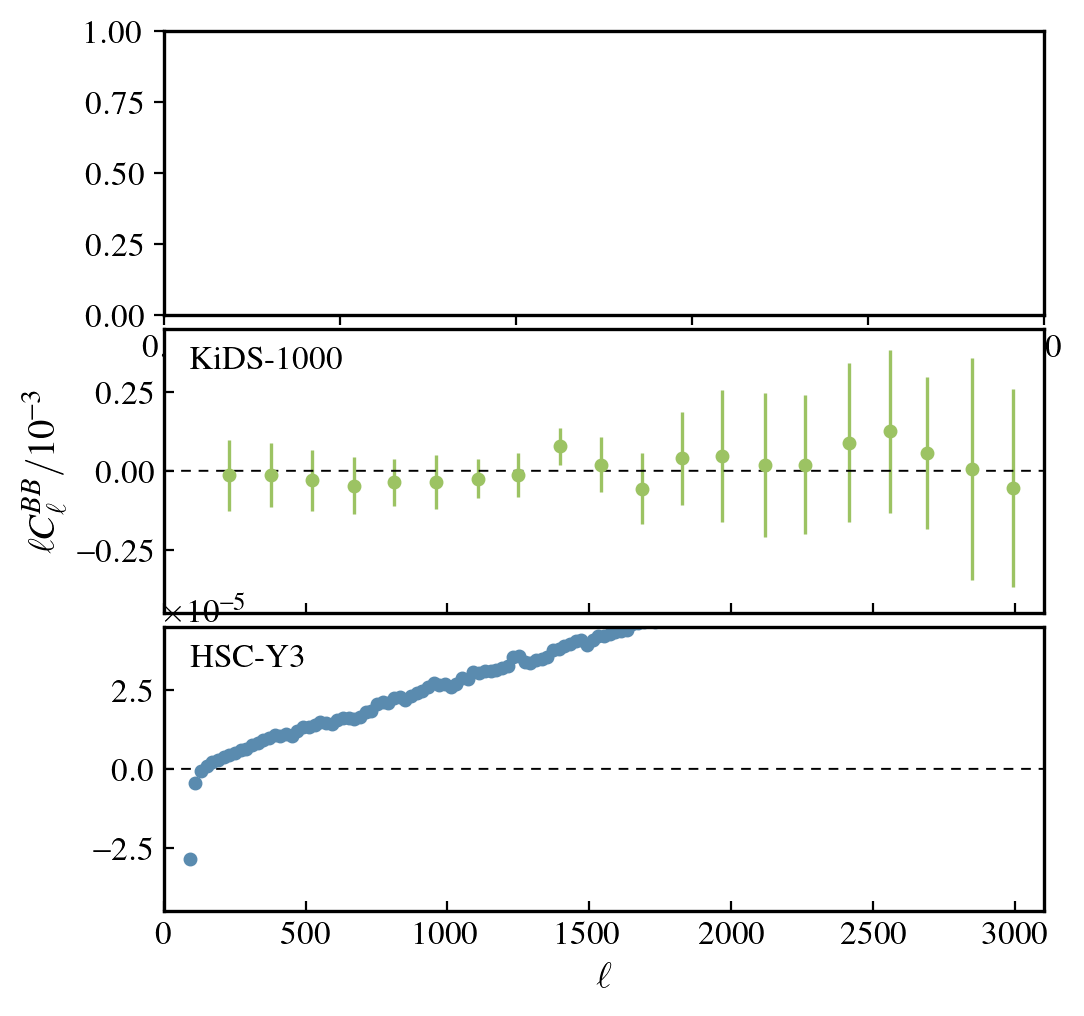

In [116]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import sacc

matplotlib.rcParams.update({'font.size': 12})


plt.clf()
fig = plt.figure(figsize=(5.5,5),dpi=100)

gs  = gridspec.GridSpec(3, 1, top=0.98, right=0.96, left=0.16, bottom=0.1,hspace=0.05,wspace=0.15)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

'''
s = sacc.Sacc.load_fits("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/desy3a/outputs/twopoint_data_fourier_pureB.sacc")

data_types = np.unique([d.data_type for d in s.data])
print("Data types: ", data_types)
print("Tracer combinations: ", s.get_tracer_combinations())
print("Size: ", s.mean.size)

l, cl0, cov0 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_0','source_0', return_cov=True)
l, cl1, cov1 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_1','source_1', return_cov=True)
l, cl2, cov2 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_2','source_2', return_cov=True)
l, cl3, cov3 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_3','source_3', return_cov=True)

#ax0.errorbar(l,cl0,yerr=np.diag(cov0)**0.5,ls='None',marker='o',elinewidth=0.7,ms=4, color='dimgray')
#ax0.errorbar(l+20,cl1,yerr=np.diag(cov1)**0.5,ls='None',marker='^',elinewidth=0.7,ms=4, color='teal')
#ax0.errorbar(l+40,cl2,yerr=np.diag(cov2)**0.5,ls='None',marker='s',elinewidth=0.7,ms=4, color='chocolate')
ax0.errorbar(l+60,cl3/1e-3,yerr=np.diag(cov2)**0.5/1e-3,ls='None',marker='o',elinewidth=1.2,ms=4, color=descol)
ax0.plot(np.zeros(3100),'k--',lw=0.7,dashes=(5,4))
ax0.set_xlim(0,3100)
ax0.set_ylim(-0.45,0.45)
plt.setp(ax0.get_xticklabels(), visible=False)
ax0.tick_params(axis="both",which='both',direction="in")
ax0.text(0.03,0.94,r'${\rm DES\textnormal{-}Y3}$',ha='left',va='top',  transform=ax0.transAxes)
''';

s = sacc.Sacc.load_fits("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/kids/outputs/meansubperfield/twopoint_data_fourier_pureB.sacc")

l, cl0, cov0 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_0','source_0', return_cov=True)
l, cl1, cov1 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_1','source_1', return_cov=True)
l, cl2, cov2 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_2','source_2', return_cov=True)
l, cl3, cov3 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_3','source_3', return_cov=True)

ax1.errorbar(l+60,cl3/1e-3,yerr=np.diag(cov2)**0.5/1e-3,ls='None',marker='o',elinewidth=1.2,ms=4, color=kidscol)
ax1.plot(np.zeros(3100),'k--',lw=0.7,dashes=(5,4))
ax1.set_xlim(0,3100)
ax1.set_ylim(-0.45,0.45)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="both",which='both',direction="in")
ax1.text(0.03,0.94,r'${\rm KiDS \textnormal{-} 1000}$',ha='left',va='top',  transform=ax1.transAxes)

ax1.set_ylabel(r"$\ell C_{\ell}^{BB}/10^{-3}$",size=14)

s = sacc.Sacc.load_fits("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/hsc-y3/outputs//shearsys/twopoint_data_fourier_pureB.sacc")

l, cl0, cov0 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_0','source_0', return_cov=True)
l, cl1, cov1 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_1','source_1', return_cov=True)
l, cl2, cov2 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_2','source_2', return_cov=True)
l, cl3, cov3 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_3','source_3', return_cov=True)

ax2.errorbar(l+60,l*cl0/1e-3,yerr=np.diag(cov2)**0.5/1e-3,ls='None',marker='o',elinewidth=1.2,ms=4, color=hsccol)
ax2.plot(np.zeros(3100),'k--',lw=0.7,dashes=(5,4))
ax2.set_xlim(0,3100)
ax2.set_ylim(-0.000045,0.000045)
#ax2.set_ylim(-45,45)

ax2.tick_params(axis="both",which='both',direction="in")
ax2.text(0.03,0.94,r'${\rm HSC}\textnormal{-}{\rm Y3}$',ha='left',va='top',  transform=ax2.transAxes)
ax2.set_xlabel(r"$\ell$",size=14)

for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(1.2)
    ax1.spines[axis].set_linewidth(1.2)
    ax2.spines[axis].set_linewidth(1.2)
    
#plt.savefig('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/plots/hybrideb.pdf',dpi=200)


In [106]:
a=np.load('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/hsc-y3/outputs//shearsys//g1.npy')

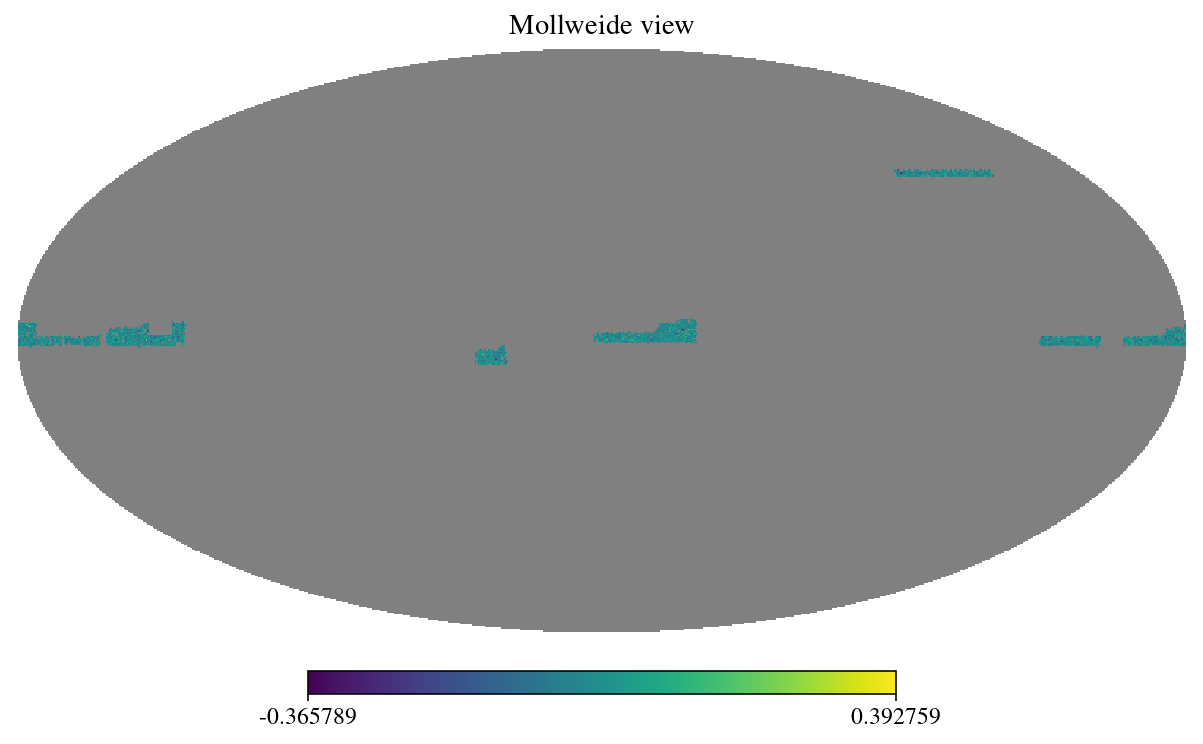

In [107]:
hp.mollview(a[0])

In [108]:
a[0]

array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
       -1.6375e+30, -1.6375e+30])

# Paper comparison plots

### DESY3

In [32]:
from astropy.io import fits
d=fits.open('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/desy3/official/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits')

xip = {}
xim = {}

for i in range(1,5):
    for j in range(i,5):
        idx = np.where( (d['xip'].data['BIN1']==i) & (d['xip'].data['BIN2']==j) )[0]
        xip['%d-%d'%(i,j)] = {'ang': d['xip'].data['ang'][idx], 'value': d['xip'].data['value'][idx]}
        
for i in range(1,5):
    for j in range(i,5):
        idx = np.where( (d['xim'].data['BIN1']==i) & (d['xim'].data['BIN2']==j) )[0]
        xim['%d-%d'%(i,j)] = {'ang': d['xim'].data['ang'][idx], 'value': d['xim'].data['value'][idx]}

11m
12m
13m
14m
44p
22m
23m
24m
34p
33p
33m
34m
24p
23p
22p
44m
14p
13p
12p
11p


Text(0.98, 0.58, '$\\theta\\times\\xi_{-}(\\theta)$')

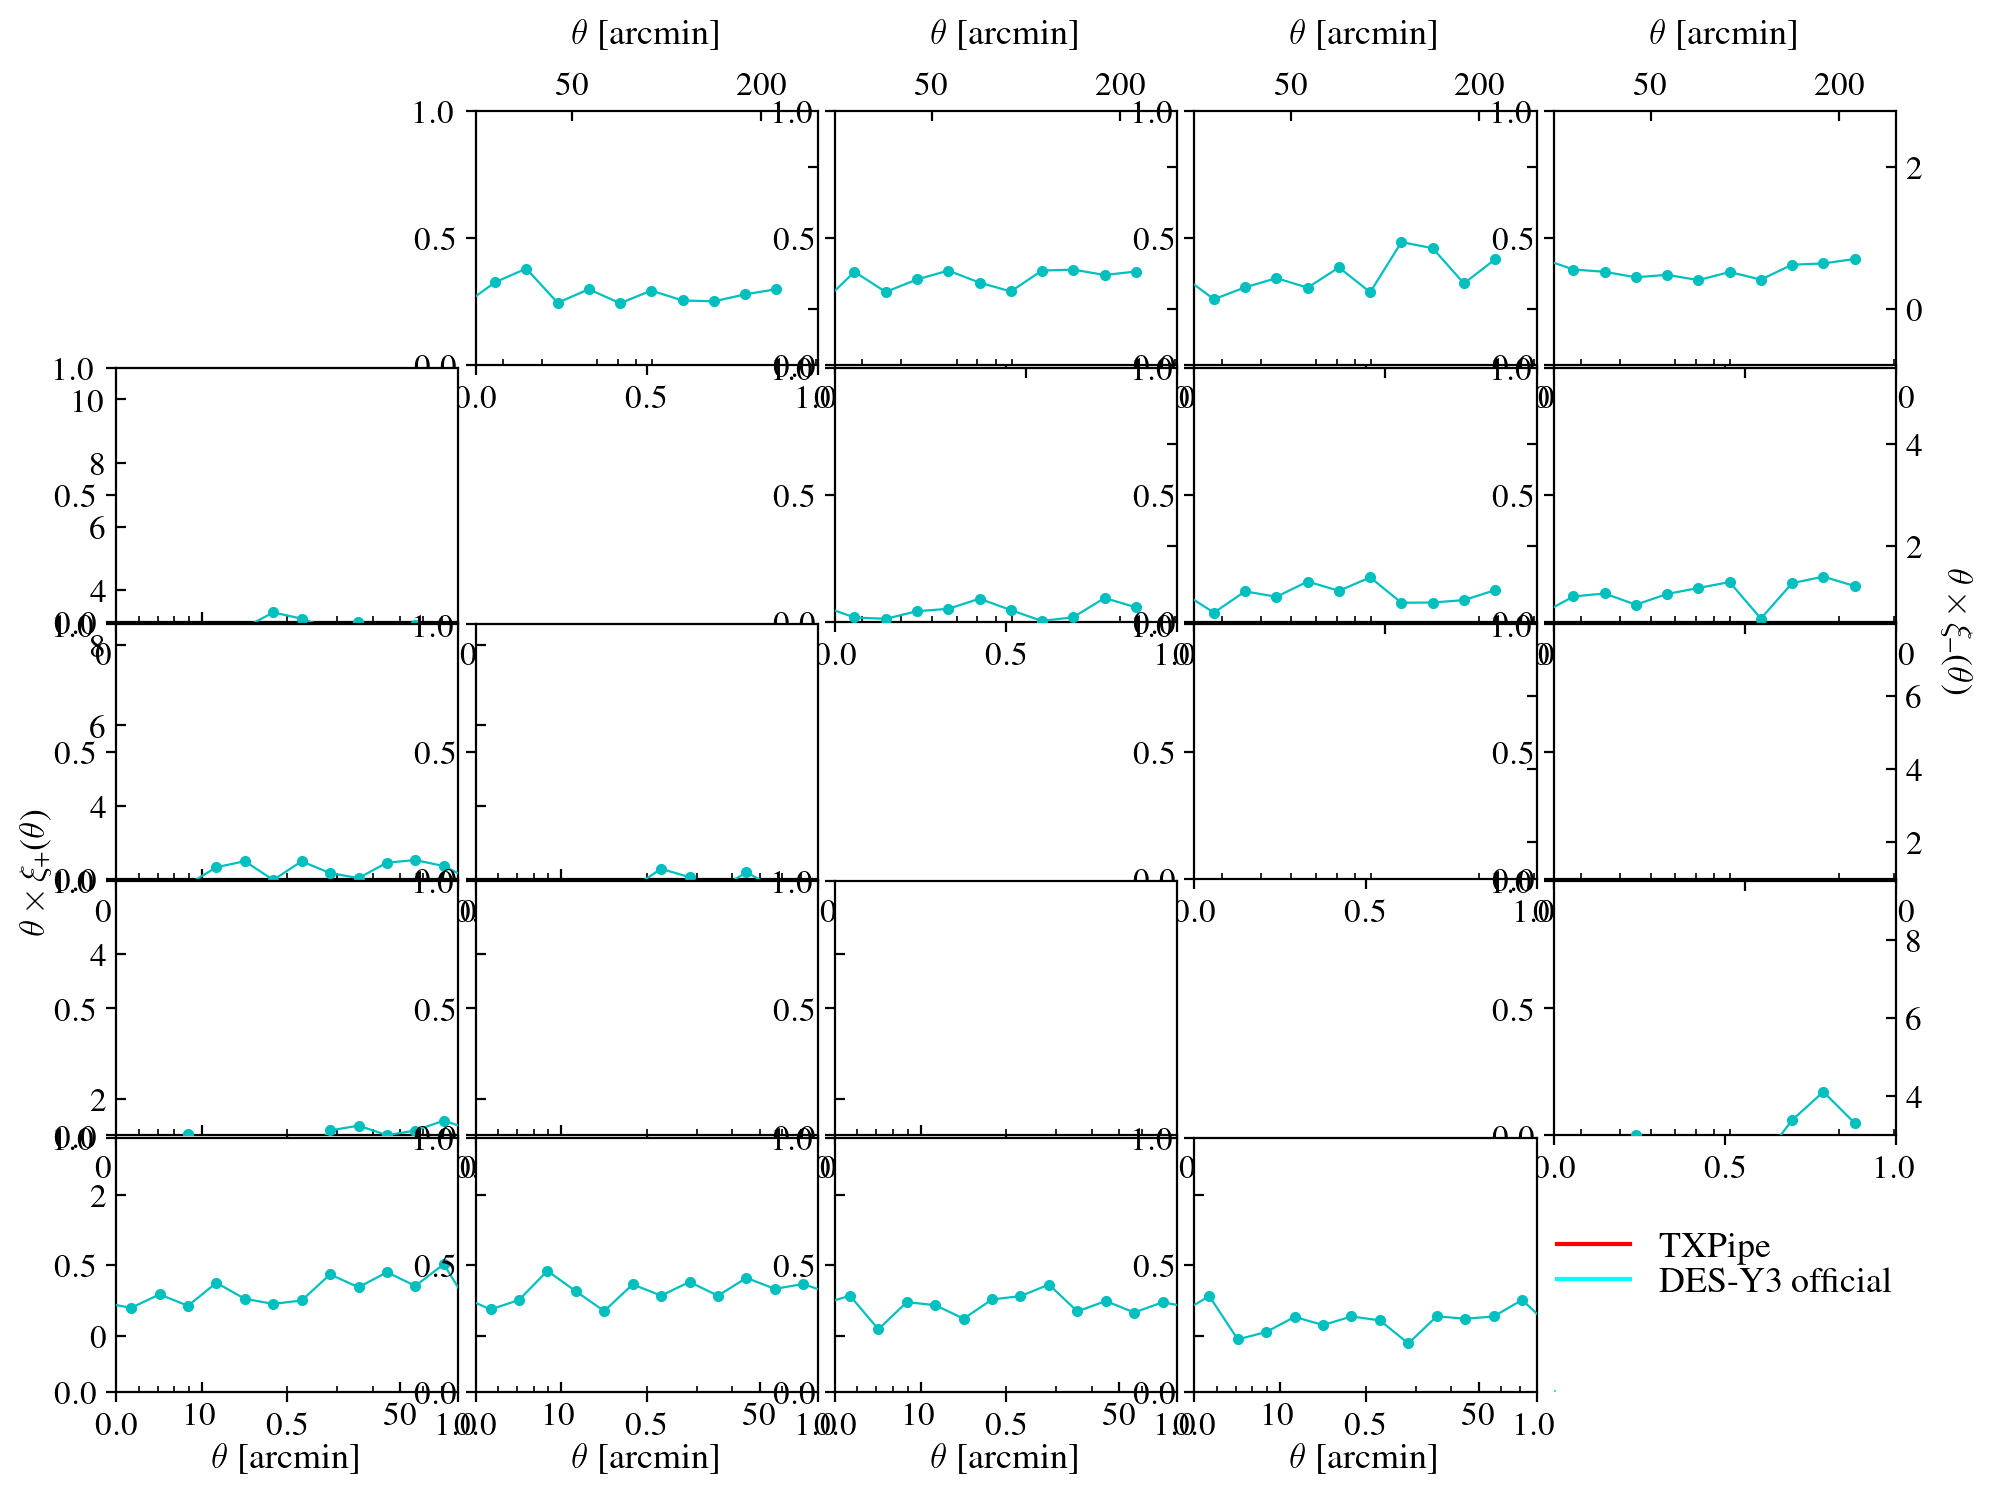

In [40]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec #import GridSpec
import sacc

matplotlib.rcParams.update({'font.size': 12})

dir = '/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/hsc-y3/data/hsc-y3/outputs/shearsys/' #scaled coupled noise
a = sacc.Sacc.load_fits(dir + 'twopoint_data_real_raw.sacc')


img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim11.png")

fig = plt.figure(figsize=(10,7.45),dpi=100,facecolor='w')


gs  = gridspec.GridSpec(5, 5,
                       #height_ratios=[4,1],
                       top=0.93,
                       bottom=0.07,
                       hspace=0.01,
                       wspace=0.05,
                       right=0.95,
                       left=0.06
                       )
plt.rcParams['axes.grid'] = False

order   = [None,'11m','12m','13m','14m',
          '44p',None ,'22m','23m','24m',
          '34p','33p',None ,'33m','34m',
          '24p','23p','22p',None ,'44m',
          '14p','13p','12p','11p',None
          ]


y = [1,1,1,1.1,1.]


c=0
for i in range(0,5):
    for j in range(0,5):
        ax = plt.subplot(gs[c])
        
        facm = y[i]*y[j]
        facp = y[4-i]*y[4-j]
    
        if order[c] is not None:
            #ax.imshow(img,  aspect='equal',alpha=0.5,extent=(24.5,305,-0.75,2.65))
            s=order[c][2]
            b1=int(order[c][0])-1
            b2=int(order[c][1])-1
            
            print(order[c])
            
            if i==0 and s=='m': 
                sign='minus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))

                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                #newax.set_ylim(-0.8,2.8)
                newax.yaxis.tick_right()
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                if j!=4: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

                newax.get_xaxis().set_major_formatter(matplotlib.ticker.NullFormatter())
                newax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
                newax.set_xticks([50,200])

                from matplotlib.ticker import ScalarFormatter
                for axis in [newax.xaxis]:
                    axis.set_major_formatter(ScalarFormatter())
                    
                newax.set_xlabel(r"$\theta\ [{\rm arcmin}]$",size=13,labelpad=10)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.xaxis.set_label_position('top')
                
            if i==1 and s=='m': 
                sign='minus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))
                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                #newax.set_ylim(0.5,5.5)
                newax.yaxis.tick_right()
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                plt.setp(newax.get_xticklabels(), visible=False)
                
                if j!=4: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
                plt.setp(newax.get_xticklabels(), visible=False)
                
            if i==2 and s=='m': 
                sign='minus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))
                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                #newax.set_ylim(1.0,7.95)
                newax.yaxis.tick_right()
                newax.set_yticks([2,4,6])
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                #newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                plt.setp(newax.get_xticklabels(), visible=False)
                
                if j!=4: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
                plt.setp(newax.get_xticklabels(), visible=False)
                
            if i==3 and s=='m': 
                sign='minus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))
                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                #newax.set_ylim(3.,9.5)
                newax.yaxis.tick_right()
                newax.set_yticks([4,6,8])
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
                plt.setp(newax.get_xticklabels(), visible=False)
                
  
            if i==1 and s=='p': 
                sign='plus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))

                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                #newax.set_ylim(3,11)
                newax.set_yticks([4,6,8,10])
                #newax.yaxis.tick_right()
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")

                
            if i==2 and s=='p': 
                sign='plus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))
                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(2.2,8.5)
                newax.set_yticks([4,6,8])
                #newax.yaxis.tick_right()
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")

                
            if i==3 and s=='p': 
                sign='plus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))
                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(1.5,5)
                #newax.yaxis.tick_right()
                newax.set_yticks([2,4])
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")

                
            if i==4 and s=='p': 
                sign='plus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))
                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(-0.8,2.8)
                #newax.yaxis.tick_right()
                newax.set_yticks([0,2])
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                
                newax.get_xaxis().set_major_formatter(matplotlib.ticker.NullFormatter())
                newax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
                newax.set_xticks([10,50])

                from matplotlib.ticker import ScalarFormatter
                for axis in [newax.xaxis]:
                    axis.set_major_formatter(ScalarFormatter())
                    
                newax.set_xlabel(r"$\theta\ [{\rm arcmin}]$",size=13 )
                newax.tick_params(axis="both",which='both',direction="in")


        else:
            ax.axis('off')
                
        #if i==0:
        #    plt.ylim(-0.75,2.65)
        #    print(ang[-8:]*val[-8:]*1e4)
           
        c+=1

ax = plt.subplot(gs[24])
ax.axis('off')
ax.plot(np.arange(10)*-100,color='r',label='TXPipe')
ax.plot(np.arange(10)*-100,color='cyan',label='DES-Y3 official')
#ax.plot(np.arange(10)*-100,color='#6774C6',label='DES-Y3 paper')


ax.set_ylim(0,2)
ax.set_xlim(0,2)
ax.legend(frameon=False,loc='center',fontsize=13,labelspacing=0.05)

newax.text(0.02, 0.42, r"$\theta\times\xi_{+}(\theta)$", transform=fig.transFigure,rotation=90,ha='center',va='center',size=13)
newax.text(0.98, 0.58, r"$\theta\times\xi_{-}(\theta)$", transform=fig.transFigure,rotation=270,ha='center',va='center',size=13)

#plt.savefig('/global/homes/y/yomori/hscy3_cosmicshear.pdf',dpi=200)

### KiDS-1000

### HSC-Y3

In [5]:
from astropy.io import fits
d=fits.open('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/official/data_extend_all_cat0.fits')

d['xi_plus']

In [6]:
xip = {}
xim = {}

for i in range(1,5):
    for j in range(i,5):
        idx = np.where( (d['xi_plus'].data['BIN1']==i) & (d['xi_plus'].data['BIN2']==j) )[0]
        xip['%d-%d'%(i,j)] = {'ang': d['xi_plus'].data['ang'][idx], 'value': d['xi_plus'].data['value'][idx]}
        
for i in range(1,5):
    for j in range(i,5):
        idx = np.where( (d['xi_minus'].data['BIN1']==i) & (d['xi_minus'].data['BIN2']==j) )[0]
        xim['%d-%d'%(i,j)] = {'ang': d['xi_minus'].data['ang'][idx], 'value': d['xi_minus'].data['value'][idx]}

11m
12m
13m
14m
44p
22m
23m
24m
34p
33p
33m
34m
24p
23p
22p
44m
14p
13p
12p
11p


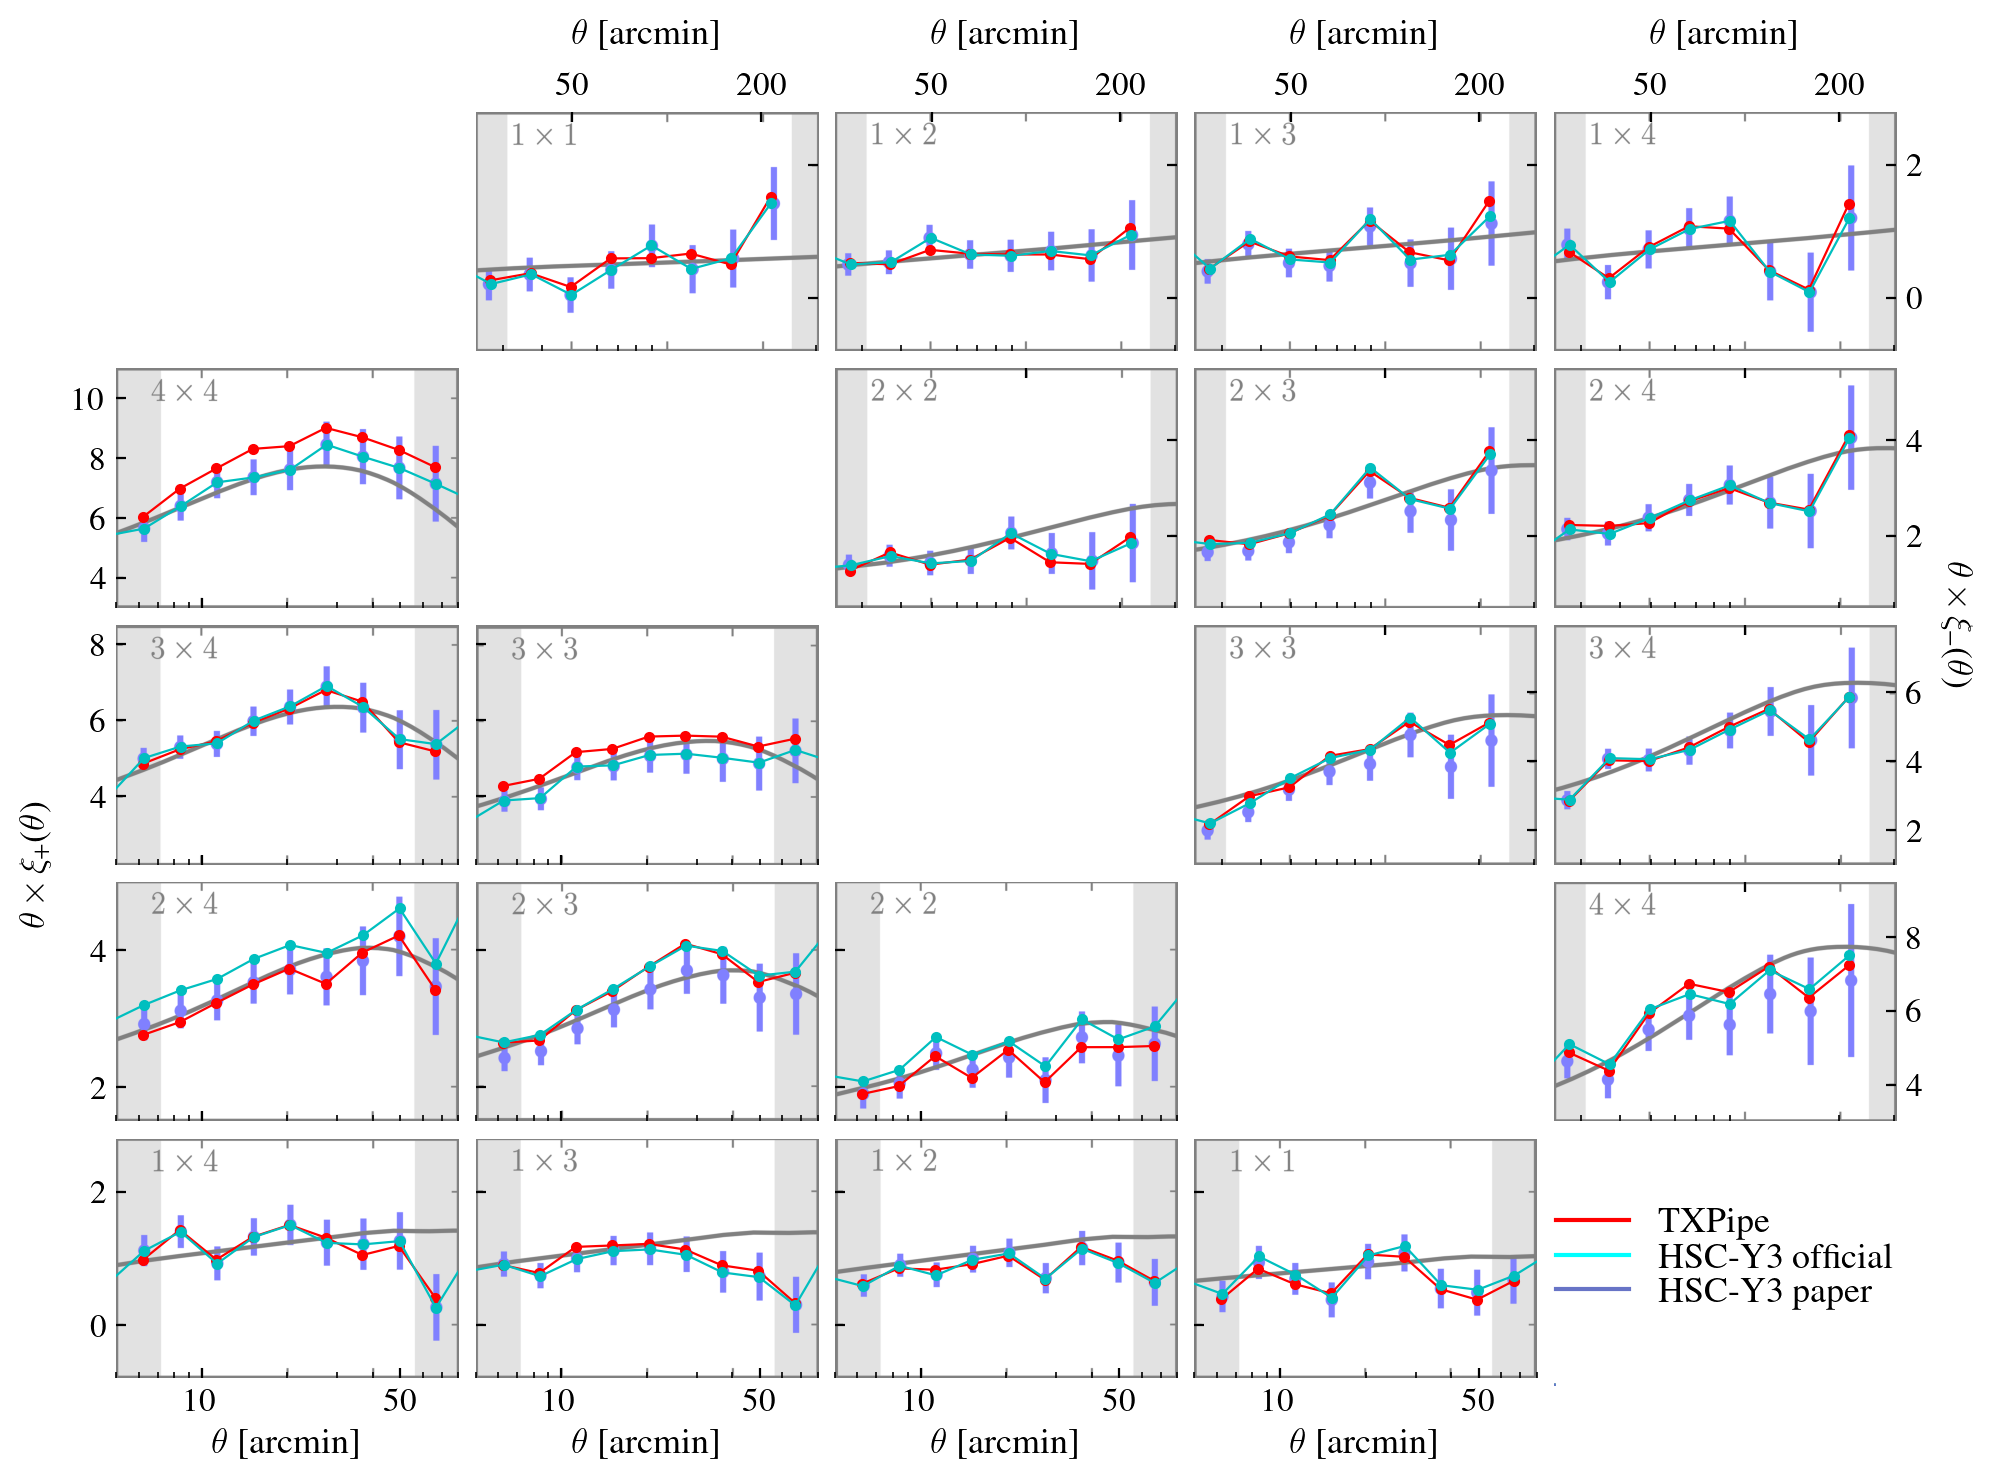

In [26]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec #import GridSpec
import sacc

matplotlib.rcParams.update({'font.size': 12})

dir = '/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/hsc-y3/data/hsc-y3/outputs/shearsys/' #scaled coupled noise
a = sacc.Sacc.load_fits(dir + 'twopoint_data_real_raw.sacc')


img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim11.png")

fig = plt.figure(figsize=(10,7.45),dpi=100,facecolor='w')


gs  = gridspec.GridSpec(5, 5,
                       #height_ratios=[4,1],
                       top=0.93,
                       bottom=0.07,
                       hspace=0.01,
                       wspace=0.05,
                       right=0.95,
                       left=0.06
                       )
plt.rcParams['axes.grid'] = False

order   = [None,'11m','12m','13m','14m',
          '44p',None ,'22m','23m','24m',
          '34p','33p',None ,'33m','34m',
          '24p','23p','22p',None ,'44m',
          '14p','13p','12p','11p',None
          ]


y = [1,1,1,1.1,1.]


c=0
for i in range(0,5):
    for j in range(0,5):
        ax = plt.subplot(gs[c])
        
        facm = y[i]*y[j]
        facp = y[4-i]*y[4-j]
    
        if order[c] is not None:
            #ax.imshow(img,  aspect='equal',alpha=0.5,extent=(24.5,305,-0.75,2.65))
            s=order[c][2]
            b1=int(order[c][0])-1
            b2=int(order[c][1])-1
            
            print(order[c])
            
            if i==0 and s=='m': 
                sign='minus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))

                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(-0.8,2.8)
                newax.yaxis.tick_right()
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                if j!=4: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

                newax.get_xaxis().set_major_formatter(matplotlib.ticker.NullFormatter())
                newax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
                newax.set_xticks([50,200])

                from matplotlib.ticker import ScalarFormatter
                for axis in [newax.xaxis]:
                    axis.set_major_formatter(ScalarFormatter())
                    
                newax.set_xlabel(r"$\theta\ [{\rm arcmin}]$",size=13,labelpad=10)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.xaxis.set_label_position('top')
                
            if i==1 and s=='m': 
                sign='minus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))
                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(0.5,5.5)
                newax.yaxis.tick_right()
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                plt.setp(newax.get_xticklabels(), visible=False)
                
                if j!=4: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
                plt.setp(newax.get_xticklabels(), visible=False)
                
            if i==2 and s=='m': 
                sign='minus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))
                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(1.0,7.95)
                newax.yaxis.tick_right()
                newax.set_yticks([2,4,6])
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                plt.setp(newax.get_xticklabels(), visible=False)
                
                if j!=4: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
                plt.setp(newax.get_xticklabels(), visible=False)
                
            if i==3 and s=='m': 
                sign='minus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))
                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(3.,9.5)
                newax.yaxis.tick_right()
                newax.set_yticks([4,6,8])
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
                plt.setp(newax.get_xticklabels(), visible=False)
                
  
            if i==1 and s=='p': 
                sign='plus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))

                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(3,11)
                newax.set_yticks([4,6,8,10])
                #newax.yaxis.tick_right()
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")

                
            if i==2 and s=='p': 
                sign='plus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))
                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(2.2,8.5)
                newax.set_yticks([4,6,8])
                #newax.yaxis.tick_right()
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")

                
            if i==3 and s=='p': 
                sign='plus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))
                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(1.5,5)
                #newax.yaxis.tick_right()
                newax.set_yticks([2,4])
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")

                
            if i==4 and s=='p': 
                sign='plus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))
                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(-0.8,2.8)
                #newax.yaxis.tick_right()
                newax.set_yticks([0,2])
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                
                newax.get_xaxis().set_major_formatter(matplotlib.ticker.NullFormatter())
                newax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
                newax.set_xticks([10,50])

                from matplotlib.ticker import ScalarFormatter
                for axis in [newax.xaxis]:
                    axis.set_major_formatter(ScalarFormatter())
                    
                newax.set_xlabel(r"$\theta\ [{\rm arcmin}]$",size=13 )
                newax.tick_params(axis="both",which='both',direction="in")


        else:
            ax.axis('off')
                
        #if i==0:
        #    plt.ylim(-0.75,2.65)
        #    print(ang[-8:]*val[-8:]*1e4)
           
        c+=1

ax = plt.subplot(gs[24])
ax.axis('off')
ax.plot(np.arange(10)*-100,color='r',label='TXPipe')
ax.plot(np.arange(10)*-100,color='cyan',label='HSC-Y3 official')
ax.plot(np.arange(10)*-100,color='#6774C6',label='HSC-Y3 paper')


ax.set_ylim(0,2)
ax.set_xlim(0,2)
ax.legend(frameon=False,loc='center',fontsize=13,labelspacing=0.05)

newax.text(0.02, 0.42, r"$\theta\times\xi_{+}(\theta)$", transform=fig.transFigure,rotation=90,ha='center',va='center',size=13)
newax.text(0.98, 0.58, r"$\theta\times\xi_{-}(\theta)$", transform=fig.transFigure,rotation=270,ha='center',va='center',size=13)

plt.savefig('/global/homes/y/yomori/hscy3_cosmicshear.pdf',dpi=200)

In [4]:
import h5py

with h5py.File('/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/hsc-y3/shear/random_cats.hdf5', "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f['randoms']['bin'].keys())
    # get first object name/key; may or may NOT be a group
    #list(f['randoms'].keys())[0]


AttributeError: 'Dataset' object has no attribute 'keys'